# What I set out to do

In this notebook I experiment with several anomaly-detection approaches on a Linux authentication log dataset. I take an iterative, exploratory approach: I engineer features focused on different attack hypotheses (brute-force, geolocation anomalies, port scanning, and privilege escalation), train simple anomaly detectors (Isolation Forests and Autoencoders), and compare their performance using ROC AUC and Average Precision.

A quick note: my results here are modest because I discovered issues with the dataset's temporal relationships and how labels were generated. I plan to fix the data-generation logic and re-run experiments for the final report. For now I document what I tried and why.

# Uploading and inspecting the dataset

I'll either upload a CSV interactively (when using Colab) or fall back to the dataset included with this notebook. Then I load it into a Pandas DataFrame and do a quick inspection (head, dtypes, and basic info) so I understand the columns, types, and any obvious issues.

In [ ]:
# I try to upload a CSV interactively if I'm on Colab; otherwise I fall back to the shipped filename.
# Uploading dataset
try:
    from google.colab import files
    uploaded = files.upload()
    csv_name = next(iter(uploaded))
except Exception:
    csv_name = "linux_auth_logs_labeled.csv"

print('csv_name set to:', csv_name)

Saving linux_auth_logs_labeled.csv to linux_auth_logs_labeled.csv
csv_name set to: linux_auth_logs_labeled.csv


In [ ]:
# I import the libraries I need for data handling, modeling and plotting.
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.ensemble import IsolationForest
from sklearn.metrics import roc_auc_score, average_precision_score

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer


import random
np.random.seed(42)
random.seed(42)
import tensorflow as tf
tf.random.set_seed(42)

import joblib

%matplotlib inline

In [ ]:
# I load the CSV into a Pandas DataFrame and display the first rows to check the data layout.
# Read the dataset and print the head
df = pd.read_csv(csv_name)

df.head()

,timestamp,source_ip,server,username,service,attempts,status,port,protocol,comment,anomaly_label
0,2023-03-01T02:34:21.401236,195.241.151.7,proxy-mow-01,achang,sudo,3,Failed,22,TELNET,User achang failed login via sudo,normal
1,2024-08-14T04:53:31.834545,164.218.94.112,srv-ldn-02,www-data,sudo,4,Failed,443,RDP,User www-data failed login via sudo,normal
2,2026-11-13T23:42:42.559210,45.250.247.54,backup-prk-01,www-data,su,2,Failed,22,TELNET,User www-data failed login via su,normal
3,2025-06-21T19:38:58.716613,114.89.244.50,srv-tok-03,juancampos,login,1,Success,22,SSH2,User juancampos success login via login,normal
4,2024-03-28T19:34:14.984218,186.144.249.195,srv-tok-03,nginx,cron,3,Failed,80,NaN,User nginx failed login via cron,normal


In [ ]:
# I inspect the DataFrame info to see column types and non-null counts.
# Dataset info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 11 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   timestamp      500000 non-null  object
 1   source_ip      500000 non-null  object
 2   server         500000 non-null  object
 3   username       500000 non-null  object
 4   service        500000 non-null  object
 5   attempts       500000 non-null  int64 
 6   status         500000 non-null  object
 7   port           500000 non-null  int64 
 8   protocol       375404 non-null  object
 9   comment        500000 non-null  object
 10  anomaly_label  500000 non-null  object
dtypes: int64(2), object(9)
memory usage: 42.0+ MB


# Preprocessing the dataset

I'll convert timestamps, create an unlabeled copy of the DataFrame for feature engineering, and clean/prepare fields that I need for each attack hypothesis.

In [ ]:
# I convert the timestamp column to datetime and create an unlabeled DataFrame for feature engineering.
# Convert the 'timestamp' column in the original df to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Drop the 'anomaly_label' column to create df_unlabeled
df_unlabeled = df.drop('anomaly_label', axis=1)

# Brute-force attack — feature engineering

Here I aggregate events per user to capture signals that indicate credential attacks: total activity, failure counts, attempts patterns, activity duration, and how many distinct IPs/servers a user touches. These features help highlight accounts that show rapid failed attempts or unusual access patterns.

In [ ]:
# Sort df_unlabeled by 'username' and 'timestamp'
df_unlabeled = df_unlabeled.sort_values(['username', 'timestamp'])

print(df_unlabeled.dtypes)
df_unlabeled.head(10)

timestamp    datetime64[ns]
source_ip            object
server               object
username             object
service              object
attempts              int64
status               object
port                  int64
protocol             object
comment              object
dtype: object


,timestamp,source_ip,server,username,service,attempts,status,port,protocol,comment
108663,2023-07-20 04:46:14.917887,125.34.181.248,srv-ldn-02,aabbott,login,1,Failed,22,NaN,User aabbott failed login via login
194452,2023-05-24 01:12:06.533286,77.254.183.133,vpn-thr-02,aadams,login,1,Success,22,TELNET,User aadams success login via login
83881,2024-12-29 11:16:35.968117,82.131.180.144,srv-nyc-01,aadams,cron,1,Success,22,SSH2,User aadams success login via cron
438598,2023-10-22 20:29:46.149145,65.193.29.148,srv-tok-03,aaguilar,ssh,1,Success,22,NaN,User aaguilar success login via ssh
6207,2024-06-16 07:39:03.982866,37.197.190.237,proxy-mow-01,aaguirre,su,1,Success,22,NaN,User aaguirre success login via su
26216,2026-12-10 08:25:17.559710,202.26.220.196,srv-nyc-01,aaguirre,cron,1,Success,2222,SSH2,User aaguirre success login via cron
267512,2025-04-29 15:34:20.976343,105.36.43.29,db-ber-01,aalexander,su,1,Success,80,NaN,User aalexander success login via su
13475,2025-07-16 13:41:09.100691,173.11.217.113,srv-nyc-01,aalexander,ssh,1,Success,443,RDP,User aalexander success login via ssh
496055,2026-03-18 13:10:28.481541,101.36.233.64,db-ber-01,aalexander,ssh,3,Failed,2222,NaN,User aalexander failed login via ssh
60131,2023-08-09 05:49:39.244709,20.6.106.163,srv-ldn-02,aallen,cron,1,Success,22,TELNET,User aallen success login via cron


In [ ]:
# I aggregate events by username to create features that summarize activity and potential brute-force behavior.
# User-level aggregated features
user_features = df.groupby('username').agg({
    'timestamp': ['count', 'min', 'max'],  # Total activities, first & last login
    'status': lambda x: (x == 'Failed').sum(),  # Total failures
    'attempts': ['sum', 'mean', 'max'],  # Attempt patterns
    'source_ip': 'nunique',  # Unique IPs used
    'service': 'nunique',  # Unique services accessed
    'server': 'nunique',  # Unique servers accessed
    'port': 'nunique'  # Unique ports used
}).reset_index()

# Flatten the column names
user_features.columns = ['username', 'total_activities', 'first_activity', 'last_activity',
                        'total_failures', 'total_attempts', 'avg_attempts', 'max_attempts',
                        'unique_ips', 'unique_services', 'unique_servers', 'unique_ports']

# Calculate derived features
user_features['failure_rate'] = user_features['total_failures'] / user_features['total_activities']
user_features['activity_duration_days'] = (user_features['last_activity'] - user_features['first_activity']).dt.total_seconds() / (24 * 3600)
user_features['activities_per_day'] = user_features['total_activities'] / user_features['activity_duration_days'].replace(0, 1)  # Avoid division by zero

In [ ]:
# Quick peek at the aggregated user features to sanity-check them
print(user_features.head(5))

     username  total_activities             first_activity  \
0     aabbott                 1 2023-07-20 04:46:14.917887   
1      aadams                 2 2023-05-24 01:12:06.533286   
2    aaguilar                 1 2023-10-22 20:29:46.149145   
3    aaguirre                 2 2024-06-16 07:39:03.982866   
4  aalexander                 3 2025-04-29 15:34:20.976343   

               last_activity  total_failures  total_attempts  avg_attempts  \
0 2023-07-20 04:46:14.917887               1               1      1.000000   
1 2024-12-29 11:16:35.968117               0               2      1.000000   
2 2023-10-22 20:29:46.149145               0               1      1.000000   
3 2026-12-10 08:25:17.559710               0               2      1.000000   
4 2026-03-18 13:10:28.481541               1               5      1.666667   

   max_attempts  unique_ips  unique_services  unique_servers  unique_ports  \
0             1           1                1               1             1   
1 

# Geolocation-based anomalies — feature engineering

I'm computing time-deltas between consecutive logins, flags for server/IP changes, consecutive-location counts, and simple risk scores that combine uniqueness and volatility of locations. The goal is to surface users whose location patterns change too quickly or don't match normal behavior.

In [ ]:
# I prepare features to capture geolocation-type anomalies: time between logins, server/ip change flags, and repeated-location groups.
# Sort by username and timestamp
df_geo = df_unlabeled.sort_values(['username', 'timestamp']).copy()

# Calculate time differences between consecutive logins
df_geo['time_since_last_login'] = df_geo.groupby('username')['timestamp'].diff()
df_geo['time_since_last_login_hours'] = df_geo['time_since_last_login'].dt.total_seconds() / 3600

# Server and IP access patterns (count occurrences)
df_geo['server_access_count'] = df_geo.groupby(['username', 'server'])['server'].transform('count')
df_geo['ip_access_count'] = df_geo.groupby(['username', 'source_ip'])['source_ip'].transform('count')

# Create change flags (these will be boolean -> can be summed)
df_geo['server_change'] = (df_geo.groupby('username')['server'].shift() != df_geo['server']).fillna(False)
df_geo['ip_change'] = (df_geo.groupby('username')['source_ip'].shift() != df_geo['source_ip']).fillna(False)

# Consecutive same location count
df_geo['location_group'] = (df_geo['server_change'] | df_geo['ip_change']).cumsum()
df_geo['consecutive_same_location'] = df_geo.groupby(['username', 'location_group']).cumcount() + 1

print("Processed data sample:")
print(df_geo[['username', 'timestamp', 'source_ip', 'server', 'time_since_last_login_hours', 'server_change']].head(10))

Processed data sample:
          username                  timestamp       source_ip        server  \
108663     aabbott 2023-07-20 04:46:14.917887  125.34.181.248    srv-ldn-02   
194452      aadams 2023-05-24 01:12:06.533286  77.254.183.133    vpn-thr-02   
83881       aadams 2024-12-29 11:16:35.968117  82.131.180.144    srv-nyc-01   
438598    aaguilar 2023-10-22 20:29:46.149145   65.193.29.148    srv-tok-03   
6207      aaguirre 2024-06-16 07:39:03.982866  37.197.190.237  proxy-mow-01   
26216     aaguirre 2026-12-10 08:25:17.559710  202.26.220.196    srv-nyc-01   
267512  aalexander 2025-04-29 15:34:20.976343    105.36.43.29     db-ber-01   
13475   aalexander 2025-07-16 13:41:09.100691  173.11.217.113    srv-nyc-01   
496055  aalexander 2026-03-18 13:10:28.481541   101.36.233.64     db-ber-01   
60131       aallen 2023-08-09 05:49:39.244709    20.6.106.163    srv-ldn-02   

        time_since_last_login_hours  server_change  
108663                          NaN           True  
1

In [ ]:
# I aggregate geolocation-related features per user: counts, time statistics, and volatility/risk scores.
# Separate aggregations by data type
basic_features = df_geo.groupby('username').agg({
    'server': 'nunique',
    'source_ip': 'nunique',
    'service': 'nunique',
    'timestamp': ['count', 'min', 'max'],
}).reset_index()
basic_features.columns = ['username', 'unique_servers', 'unique_ips', 'unique_services', 'total_logins', 'first_seen', 'last_seen']

# For numeric features - handle NaN during aggregation
numeric_features = df_geo.groupby('username').agg({
    'time_since_last_login_hours': ['mean', 'std', 'min', 'max'],
    'server_access_count': ['mean', 'max'],
    'ip_access_count': ['mean', 'max'],
    'attempts': ['mean', 'max', 'sum'],
    'port': 'nunique',
}).reset_index()
numeric_features.columns = ['username', 'avg_time_between_logins', 'std_time_between_logins', 'min_time_between_logins',
                           'max_time_between_logins', 'avg_server_access', 'max_server_access', 'avg_ip_access',
                           'max_ip_access', 'avg_attempts', 'max_attempts', 'total_attempts', 'unique_ports']

# Boolean features
boolean_features = df_geo.groupby('username').agg({
    'server_change': 'sum',
    'ip_change': 'sum',
    'consecutive_same_location': 'max',
}).reset_index()
boolean_features.columns = ['username', 'server_changes', 'ip_changes', 'max_consecutive_same_location']

# Status features
status_features = df_geo.groupby('username').agg({
    'status': lambda x: (x == 'failure').sum(),
}).reset_index()
status_features.columns = ['username', 'failed_logins']

# Merge all features
geo_features = basic_features.merge(numeric_features, on='username', how='left')
geo_features = geo_features.merge(boolean_features, on='username', how='left')
geo_features = geo_features.merge(status_features, on='username', how='left')

#handle devision by zero
geo_features['active_days'] = (
    (geo_features['last_seen'] - geo_features['first_seen']).dt.total_seconds() / (24 * 3600)
).replace(0, 1)  # Avoid division by zero

# Safe division to prevent NaN
geo_features['logins_per_day'] = np.where(
    geo_features['active_days'] > 0,
    geo_features['total_logins'] / geo_features['active_days'],
    0
)
geo_features['servers_per_login'] = np.where(
    geo_features['total_logins'] > 0,
    geo_features['unique_servers'] / geo_features['total_logins'],
    0
)
geo_features['ips_per_login'] = np.where(
    geo_features['total_logins'] > 0,
    geo_features['unique_ips'] / geo_features['total_logins'],
    0
)
geo_features['failure_rate'] = np.where(
    geo_features['total_logins'] > 0,
    geo_features['failed_logins'] / geo_features['total_logins'],
    0
)

# Handle NaN in std_time_between_logins (occurs when users have only one login)
geo_features['std_time_between_logins'] = geo_features['std_time_between_logins'].fillna(0)

# Risk scores
geo_features['location_volatility'] = np.where(
    geo_features['total_logins'] > 0,
    (geo_features['server_changes'] + geo_features['ip_changes']) / geo_features['total_logins'],
    0
)

geo_features['geo_risk_score'] = (
    geo_features['unique_ips'] * 0.3 +
    geo_features['unique_servers'] * 0.3 +
    geo_features['location_volatility'] * 0.2 +
    geo_features['failure_rate'] * 0.2
)

# Fill any remaining NaN values with median
numeric_cols = geo_features.select_dtypes(include=np.number).columns
geo_features[numeric_cols] = geo_features[numeric_cols].fillna(geo_features[numeric_cols].median())

print(f"\nRemaining NaN values in geo_features: {geo_features.isnull().sum().sum()}")


Remaining NaN values in geo_features: 0


# Port-scanning features

For port-scanning detection I look at activity grouped by source IP and small time windows (15 minutes). I engineer features like total port attempts, number of unique ports, ports-per-minute, port-range and failure/success ratios to surface scanning-like behavior.

In [ ]:
# For port scanning we want the DataFrame sorted by source_ip and timestamp
df_by_source = df.sort_values(['source_ip', 'timestamp'])

In [ ]:
# Add a 15-minute floor time window column on the df_by_source DataFrame
df_by_source['time_window'] = df_by_source['timestamp'].dt.floor('15min')

In [ ]:
# I aggregate port activity per source IP within 15-minute windows and engineer features that indicate scanning behavior.
# Aggregate port scanning features per source_ip/time_window using df_by_source
port_scan_features = df_by_source.groupby(['source_ip', 'time_window']).agg({
    'port': [
        'count',  # total_port_attempts
        'nunique',  # unique_ports_scanned
        lambda x: (x > 10000).sum(),  # high_port_attempts (verify threshold)
        'min',  # min_port
        'max',  # max_port
        lambda x: np.std(x) if len(x) > 1 else 0,  # port_std_dev
    ],
    'status': [
        lambda x: (x == 'Failed').sum(),  # failed_attempts
        lambda x: (x == 'Success').sum(),  # success_attempts
    ],
    'server': 'nunique',  # unique_servers_targeted
    'service': 'nunique',  # unique_services_accessed
    'username': 'nunique',  # unique_usernames_tried
}).reset_index()

In [ ]:
# I simplify the multi-index columns produced by aggregation into flat, readable names.
port_scan_features.columns = [
    'source_ip', 'time_window',
    'total_port_attempts', 'unique_ports_scanned', 'high_port_attempts',
    'min_port', 'max_port', 'port_std_dev',
    'failed_attempts', 'success_attempts',
    'unique_servers', 'unique_services', 'unique_usernames',


In [ ]:
# I create derived port-scanning metrics such as range, ratios and per-minute rates for later use.
port_scan_features['port_range'] = port_scan_features['max_port'] - port_scan_features['min_port']
port_scan_features['high_port_ratio'] = port_scan_features['high_port_attempts'] / port_scan_features['total_port_attempts']
port_scan_features['failure_rate'] = port_scan_features['failed_attempts'] / port_scan_features['total_port_attempts']
port_scan_features['success_rate'] = port_scan_features['success_attempts'] / port_scan_features['total_port_attempts']
port_scan_features['ports_per_minute'] = port_scan_features['unique_ports_scanned'] / 15  # 15-minute windows

In [ ]:
# I clean infinities/NaNs from the port features and print a quick sample to sanity-check.
port_scan_features = port_scan_features.replace([np.inf, -np.inf], 0).fillna(0)

print("Port scanning features shape:", port_scan_features.shape)
print("\nFeatures created:")
print(port_scan_features.columns.tolist())
print("\nSample of engineered features:")
print(port_scan_features.head())

Port scanning features shape: (500000, 18)

Features created:
['source_ip', 'time_window', 'total_port_attempts', 'unique_ports_scanned', 'high_port_attempts', 'min_port', 'max_port', 'port_std_dev', 'failed_attempts', 'success_attempts', 'unique_servers', 'unique_services', 'unique_usernames', 'port_range', 'high_port_ratio', 'failure_rate', 'success_rate', 'ports_per_minute']

Sample of engineered features:
     source_ip         time_window  total_port_attempts  unique_ports_scanned  \
0   1.0.134.33 2025-01-16 15:45:00                    1                     1   
1  1.0.160.135 2026-09-11 12:15:00                    1                     1   
2    1.0.23.53 2023-01-25 20:15:00                    1                     1   
3   1.0.231.27 2023-11-12 11:45:00                    1                     1   
4  1.0.241.235 2023-10-05 06:30:00                    1                     1   

   high_port_attempts  min_port  max_port  port_std_dev  failed_attempts  \
0                   0   

# Privilege escalation — feature engineering

I search for evidence of privilege-related activity in free-text fields (comments) and count occurrences of common privilege keywords. I also aggregate per-user service/server usage and attempt statistics to identify users showing suspicious privilege-seeking behavior.

In [ ]:
df_by_user = df.sort_values(['username', 'timestamp'])

df_by_user.head(10)

,timestamp,source_ip,server,username,service,attempts,status,port,protocol,comment,anomaly_label
108663,2023-07-20 04:46:14.917887,125.34.181.248,srv-ldn-02,aabbott,login,1,Failed,22,NaN,User aabbott failed login via login,normal
194452,2023-05-24 01:12:06.533286,77.254.183.133,vpn-thr-02,aadams,login,1,Success,22,TELNET,User aadams success login via login,normal
83881,2024-12-29 11:16:35.968117,82.131.180.144,srv-nyc-01,aadams,cron,1,Success,22,SSH2,User aadams success login via cron,normal
438598,2023-10-22 20:29:46.149145,65.193.29.148,srv-tok-03,aaguilar,ssh,1,Success,22,NaN,User aaguilar success login via ssh,normal
6207,2024-06-16 07:39:03.982866,37.197.190.237,proxy-mow-01,aaguirre,su,1,Success,22,NaN,User aaguirre success login via su,normal
26216,2026-12-10 08:25:17.559710,202.26.220.196,srv-nyc-01,aaguirre,cron,1,Success,2222,SSH2,User aaguirre success login via cron,normal
267512,2025-04-29 15:34:20.976343,105.36.43.29,db-ber-01,aalexander,su,1,Success,80,NaN,User aalexander success login via su,normal
13475,2025-07-16 13:41:09.100691,173.11.217.113,srv-nyc-01,aalexander,ssh,1,Success,443,RDP,User aalexander success login via ssh,normal
496055,2026-03-18 13:10:28.481541,101.36.233.64,db-ber-01,aalexander,ssh,3,Failed,2222,NaN,User aalexander failed login via ssh,normal
60131,2023-08-09 05:49:39.244709,20.6.106.163,srv-ldn-02,aallen,cron,1,Success,22,TELNET,User aallen success login via cron,normal


In [ ]:
# I look for comments containing common privilege-escalation keywords and aggregate per-user counts.

priv_keywords = [
    "sudo", "su -", "root", "chmod 777", "chown", "setuid", "setgid",
    "privilege", "escalate", "elevate", "exploit", "admin access",
    "bypass", "shell", "spawn", "superuser", "policy"
]

def has_priv_keyword(text):
    # Handle NaNs and non-string values safely
    if not isinstance(text, str) or not text:
        return False
    text = text.lower()
    return any(k in text for k in priv_keywords)


priv_user_features = df_by_user.groupby('username').agg({
    'timestamp': ['count', 'min', 'max'],
    'comment': lambda x: sum(has_priv_keyword(t) for t in x),
    'service': 'nunique',
    'server': 'nunique',
    'attempts': ['sum', 'mean', 'max']}).reset_index()

In [ ]:

priv_user_features.columns = [
    'username',
    'total_activities', 'first_activity', 'last_activity',
    'priv_keyword_count',
    'unique_services', 'unique_servers',
    'total_attempts', 'avg_attempts', 'max_attempts',
]


priv_user_features['priv_keyword_rate'] = (
    priv_user_features['priv_keyword_count'] / priv_user_features['total_activities']
)


priv_user_features['activity_duration_days'] = (
    (priv_user_features['last_activity'] - priv_user_features['first_activity'])
    .dt.total_seconds() / (24 * 3600)
)


priv_user_features['activities_per_day'] = (
    priv_user_features['total_activities'] /
    priv_user_features['activity_duration_days'].replace(0, 1)
)

In [ ]:
print(priv_user_features.head(10))
print(priv_user_features.describe())


print(priv_user_features.sort_values('priv_keyword_count', ascending=False).head(10))

     username  total_activities             first_activity  \
0     aabbott                 1 2023-07-20 04:46:14.917887   
1      aadams                 2 2023-05-24 01:12:06.533286   
2    aaguilar                 1 2023-10-22 20:29:46.149145   
3    aaguirre                 2 2024-06-16 07:39:03.982866   
4  aalexander                 3 2025-04-29 15:34:20.976343   
5      aallen                 4 2023-08-09 05:49:39.244709   
6    aallison                 2 2023-05-01 18:31:16.665655   
7    aalvarez                 3 2024-06-11 02:39:19.352079   
8   aanderson                12 2023-02-02 19:46:35.024347   
9    aandrews                 1 2025-01-21 15:04:11.062003   

               last_activity  priv_keyword_count  unique_services  \
0 2023-07-20 04:46:14.917887                   0                1   
1 2024-12-29 11:16:35.968117                   0                2   
2 2023-10-22 20:29:46.149145                   0                1   
3 2026-12-10 08:25:17.559710             

# Scaling and PCA preparation

I'm standardizing numerical features and running PCA to reduce dimensionality while preserving most of the variance. I use PCA both as a selection method and to produce compact inputs for models where appropriate.

In [ ]:
# Identify numerical columns to be used for scaling and PCA
numerical_cols_bf = user_features.select_dtypes(include=np.number).columns.tolist()

# Exclude 'username' and timestamp columns
exclude_cols = ['username', 'first_activity', 'last_activity']
bf_features_for_scaling = [col for col in numerical_cols_bf if col not in exclude_cols]

# Select only the features for scaling
X_bf_numerical = user_features[bf_features_for_scaling]

# Initialize StandardScaler
scaler = StandardScaler()

# Fit and transform the numerical features
scaled_bf_features = scaler.fit_transform(X_bf_numerical)

print("Shape of scaled brute force features:", scaled_bf_features.shape)
print("First 5 rows of scaled brute force features:\n", scaled_bf_features[:5])

# --- PCA for brute-force features ---
from sklearn.decomposition import PCA
pca_bf = PCA(n_components=0.95)  # retain 95% variance
pca_bf_features = pca_bf.fit_transform(scaled_bf_features)
pca_bf_df = pd.DataFrame(pca_bf_features, columns=[f'PC_{i+1}' for i in range(pca_bf_features.shape[1])])
print(f"Number of components for Brute-force PCA: {pca_bf.n_components_}")
print(f"Explained variance ratio for Brute-force PCA: {pca_bf.explained_variance_ratio_.sum():.2f}")
print("\nFirst 5 rows of PCA transformed Brute-force features:")
print(pca_bf_df.head())

Shape of scaled brute force features: (95426, 12)
First 5 rows of scaled brute force features:
 [[-0.00906024 -0.00691729 -0.00843865 -0.63058465 -0.64836751 -0.00906026
  -0.44919203 -0.42661683 -0.04437292  1.07867496 -0.46988284  0.35506628]
 [-0.00692322 -0.01107734 -0.00753363 -0.63058465 -0.64836751 -0.00692321
   0.96781949  0.67994304 -0.04437292 -1.08671282  1.26346894 -1.14238718]
 [-0.00906024 -0.01107734 -0.00843865 -0.63058465 -0.64836751 -0.00906026
  -0.44919203 -0.42661683 -0.04437292 -1.08671282 -0.46988284  0.35506628]
 [-0.00692322 -0.01107734 -0.00753363 -0.63058465 -0.64836751 -0.00692321
   0.96781949  0.67994304  0.1006235  -1.08671282  2.21572114 -1.14420735]
 [-0.0047862  -0.00691729 -0.00481858  0.06960138  1.00808854 -0.00478616
   0.96781949  0.67994304  0.24561992 -0.36491689  0.48618228 -1.13356031]]
Number of components for Brute-force PCA: 5
Explained variance ratio for Brute-force PCA: 0.96

First 5 rows of PCA transformed Brute-force features:
       P

In [ ]:
# Prepare numeric geolocation features and scale them before PCA
numerical_cols_geo = geo_features.select_dtypes(include=np.number).columns.tolist()
exclude_cols_geo = ['username', 'first_seen', 'last_seen']
geo_features_for_scaling = [c for c in numerical_cols_geo if c not in exclude_cols_geo]
X_geo_numerical = geo_features[geo_features_for_scaling]
scaler_geo = StandardScaler()
scaled_geo_features = scaler_geo.fit_transform(X_geo_numerical)

# Initialize PCA for geolocation features
pca_geo = PCA(n_components=0.95) # Retain 95% of variance

# Fit PCA to the scaled data and transform it
pca_geo_features = pca_geo.fit_transform(scaled_geo_features)

# Create a DataFrame from the PCA transformed features for better readability
pca_geo_df = pd.DataFrame(pca_geo_features, columns=[f'PC_{i+1}' for i in range(pca_geo_features.shape[1])])

print(f"Number of components for Geolocation PCA: {pca_geo.n_components_}")
print(f"Explained variance ratio for Geolocation PCA: {pca_geo.explained_variance_ratio_.sum():.2f}")
print("\nFirst 5 rows of PCA transformed Geolocation features:")
print(pca_geo_df.head())

Number of components for Geolocation PCA: 7
Explained variance ratio for Geolocation PCA: 0.96

First 5 rows of PCA transformed Geolocation features:
       PC_1      PC_2      PC_3      PC_4      PC_5      PC_6      PC_7
0 -0.091354 -1.084159  0.151504 -0.735462  0.003250 -0.074146  0.133705
1 -0.275010  1.884549  2.288310 -0.824001  0.616246 -0.045084 -1.437938
2 -0.091354 -1.084159  0.151504 -0.735462  0.003250 -0.074146  0.133705
3 -0.278983  3.381494  5.631015 -0.679520  0.492120 -0.138086 -1.230753
4  0.172101  2.039124 -3.116154  0.007776 -0.593849  0.136991 -0.226044


In [ ]:
numerical_cols_ps = port_scan_features.select_dtypes(include=np.number).columns.tolist()


exclude_cols_ps = ['source_ip', 'time_window']
ps_features_for_scaling = [col for col in numerical_cols_ps if col not in exclude_cols_ps]


X_ps_numerical = port_scan_features[ps_features_for_scaling]

scaler_ps = StandardScaler()

scaled_ps_features = scaler_ps.fit_transform(X_ps_numerical)

print("Shape of scaled port scanning features:", scaled_ps_features.shape)
print("First 5 rows of scaled port scanning features:\n", scaled_ps_features[:5])

Shape of scaled port scanning features: (500000, 16)
First 5 rows of scaled port scanning features:
 [[ 0.00000000e+00  0.00000000e+00 -1.03387849e-01 -2.00670486e-01
  -2.00670486e-01  0.00000000e+00  9.83736237e-01 -9.83736237e-01
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  -1.03387849e-01  9.83736237e-01 -9.83736237e-01 -8.32667268e-17]
 [ 0.00000000e+00  0.00000000e+00 -1.03387849e-01 -1.86913781e-01
  -1.86913781e-01  0.00000000e+00  9.83736237e-01 -9.83736237e-01
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  -1.03387849e-01  9.83736237e-01 -9.83736237e-01 -8.32667268e-17]
 [ 0.00000000e+00  0.00000000e+00 -1.03387849e-01 -2.00670486e-01
  -2.00670486e-01  0.00000000e+00 -1.01653265e+00  1.01653265e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  -1.03387849e-01 -1.01653265e+00  1.01653265e+00 -8.32667268e-17]
 [ 0.00000000e+00  0.00000000e+00 -1.03387849e-01 -1.00815783e-01
  -1.00815783e-01  0.00000000e+00 -1.0

In [ ]:
pca_ps = PCA(n_components=0.95)


pca_ps_features = pca_ps.fit_transform(scaled_ps_features)

pca_ps_df = pd.DataFrame(pca_ps_features, columns=[f'PC_{i+1}' for i in range(pca_ps_features.shape[1])])

print(f"Number of components for Port Scanning PCA: {pca_ps.n_components_}")
print(f"Explained variance ratio for Port Scanning PCA: {pca_ps.explained_variance_ratio_.sum():.2f}")
print("\nFirst 5 rows of PCA transformed Port Scanning features:")
print(pca_ps_df.head())

Number of components for Port Scanning PCA: 2
Explained variance ratio for Port Scanning PCA: 0.97

First 5 rows of PCA transformed Port Scanning features:
       PC_1      PC_2
0  1.369149 -1.445831
1  1.377533 -1.434916
2 -1.792906  1.004764
3 -1.732048  1.083990
4  1.369149 -1.445831


In [ ]:
numerical_cols_priv = priv_user_features.select_dtypes(include=np.number).columns.tolist()


exclude_cols_priv = ['username', 'first_activity', 'last_activity']
priv_features_for_scaling = [col for col in numerical_cols_priv if col not in exclude_cols_priv]


X_priv_numerical = priv_user_features[priv_features_for_scaling]


scaler_priv = StandardScaler()


scaled_priv_features = scaler_priv.fit_transform(X_priv_numerical)

print("Shape of scaled privilege escalation features:", scaled_priv_features.shape)
print("First 5 rows of scaled privilege escalation features:\n", scaled_priv_features[:5])

Shape of scaled privilege escalation features: (95426, 10)
First 5 rows of scaled privilege escalation features:
 [[-0.00906024 -0.00737687 -0.44919203 -0.42661683 -0.00843865 -0.63058465
  -0.64836751 -0.53903691 -0.46988284  0.35506628]
 [-0.00692322 -0.00737687  0.96781949  0.67994304 -0.00753363 -0.63058465
  -0.64836751 -0.53903691  1.26346894 -1.14238718]
 [-0.00906024 -0.00737687 -0.44919203 -0.42661683 -0.00843865 -0.63058465
  -0.64836751 -0.53903691 -0.46988284  0.35506628]
 [-0.00692322 -0.00737687  0.96781949  0.67994304 -0.00753363 -0.63058465
  -0.64836751 -0.53903691  2.21572114 -1.14420735]
 [-0.0047862  -0.00737687  0.96781949  0.67994304 -0.00481858  0.06960138
   1.00808854 -0.53903691  0.48618228 -1.13356031]]


In [ ]:
pca_priv = PCA(n_components=0.95)


pca_priv_features = pca_priv.fit_transform(scaled_priv_features)


pca_priv_df = pd.DataFrame(pca_priv_features, columns=[f'PC_{i+1}' for i in range(pca_priv_features.shape[1])])

print(f"Number of components for Privilege Escalation PCA: {pca_priv.n_components_}")
print(f"Explained variance ratio for Privilege Escalation PCA: {pca_priv.explained_variance_ratio_.sum():.2f}")
print("\nFirst 5 rows of PCA transformed Privilege Escalation features:")
print(pca_priv_df.head())

Number of components for Privilege Escalation PCA: 6
Explained variance ratio for Privilege Escalation PCA: 0.96

First 5 rows of PCA transformed Privilege Escalation features:
       PC_1      PC_2      PC_3      PC_4      PC_5      PC_6
0  0.789711 -0.719967 -0.638597 -0.531233  0.066893 -0.020818
1 -1.687820  0.453074 -1.283550 -0.524021 -0.468530  0.304870
2  0.789711 -0.719967 -0.638597 -0.531233  0.066893 -0.020818
3 -2.090746  0.720222 -1.420323 -0.522153 -0.442768  0.828036
4 -1.503985  0.936716  0.297280 -0.544049 -0.454582 -0.050746


# Feature selection strategy

I experiment with three complementary approaches to pick features:

- Heuristic selection based on domain knowledge (what I think should matter).
- Variance-based selection to pick features that actually change across users/sessions.
- PCA loadings to identify features that carry the strongest signal in top principal components.

I compare these sets downstream to see which selection method gives the best anomaly-detection performance.

In [ ]:
def select_features_by_attack_type(attack_type):
    """Return a heuristic list of columns to keep for the given attack type.
    This is based on the engineered feature DataFrames created previously:
    - 'brute_force' -> `user_features`
    - 'geolocation' -> `geo_features`
    - 'port_scan' -> `port_scan_features`
    - 'privilege' -> `priv_user_features`
    """
    attack_type = attack_type.lower()
    if attack_type == 'brute_force' or attack_type == 'bruteforce':
        return [
            'total_activities', 'total_failures', 'failure_rate',
            'avg_attempts', 'max_attempts', 'activities_per_day',
            'unique_ips'
        ]
    elif attack_type == 'geolocation' or attack_type == 'geo':
        return [
            'unique_ips', 'unique_servers', 'unique_services',
            'logins_per_day', 'active_days', 'geo_risk_score'
        ]
    elif attack_type == 'port_scan' or attack_type == 'port_scanning':
        return [
            'total_port_attempts', 'unique_ports_scanned', 'ports_per_minute',
            'port_range', 'high_port_ratio', 'unique_services', 'unique_usernames'
        ]
    elif attack_type == 'privilege' or attack_type == 'priv_escalation':
        return [
            'priv_keyword_count', 'priv_keyword_rate', 'activities_per_day',
            'unique_services', 'unique_servers'
        ]
    else:

        return None

def variance_based_selection(df, top_k=10, corr_threshold=0.9):
    """Select top_k features by variance, then drop highly correlated features.
    Returns ordered list of selected columns.
    """

    num = df.select_dtypes(include=[np.number]).copy()
    if num.shape[1] == 0:
        return []
    variances = num.var().sort_values(ascending=False)
    top_cols = variances.head(top_k).index.tolist()


    keep = []
    corr = num[top_cols].corr().abs()
    for col in top_cols:
        if not any((corr.loc[col, other] > corr_threshold) for other in keep):
            keep.append(col)
    return keep

def pca_loadings_selection(df, n_components=5, top_k=10):
    """Use PCA loadings to pick features that have large absolute weights
    across the first `n_components` principal components.
    Returns a list of selected column names.
    """
    num = df.select_dtypes(include=[np.number]).copy()
    if num.shape[1] == 0:
        return []

    scaler_tmp = StandardScaler()
    X = scaler_tmp.fit_transform(num.fillna(0))
    pca_tmp = PCA(n_components=min(n_components, X.shape[1]))
    pca_tmp.fit(X)
    loadings = np.abs(pca_tmp.components_).sum(axis=0)
    feature_scores = pd.Series(loadings, index=num.columns)
    selected = feature_scores.sort_values(ascending=False).head(top_k).index.tolist()
    return selected

def prepare_selected_features(df, selected_cols, scaler=None):
    """Given a DataFrame and a list of columns, return scaled numpy array
    ready for anomaly models and the fitted scaler.
    """
    if selected_cols is None:

        selected_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    X = df[selected_cols].fillna(0).astype(float)
    if scaler is None:
        scaler = StandardScaler()
        Xs = scaler.fit_transform(X)
    else:
        Xs = scaler.transform(X)
    return Xs, scaler, selected_cols

In [ ]:
results = {}

# 1) Brute-force (user_features)
bf_cols = select_features_by_attack_type('brute_force')
bf_selected_variance = variance_based_selection(user_features, top_k=8, corr_threshold=0.9)
bf_selected_pca = pca_loadings_selection(user_features, n_components=3, top_k=8)
bf_X_heur, bf_scaler, bf_cols_used = prepare_selected_features(user_features, bf_cols)
bf_X_var, _, bf_cols_var = prepare_selected_features(user_features, bf_selected_variance)
bf_X_pca, _, bf_cols_pca = prepare_selected_features(user_features, bf_selected_pca)
results['brute_force'] = {
    'heuristic_cols': bf_cols_used,
    'variance_cols': bf_cols_var,
    'pca_cols': bf_cols_pca,
    'heuristic_array': bf_X_heur,
    'variance_array': bf_X_var,
    'pca_array': bf_X_pca
}

# 2) Geolocation (geo_features)
geo_cols = select_features_by_attack_type('geolocation')
geo_selected_variance = variance_based_selection(geo_features, top_k=6, corr_threshold=0.9)
geo_selected_pca = pca_loadings_selection(geo_features, n_components=3, top_k=6)
geo_X_heur, geo_scaler, geo_cols_used = prepare_selected_features(geo_features, geo_cols)
geo_X_var, _, geo_cols_var = prepare_selected_features(geo_features, geo_selected_variance)
geo_X_pca, _, geo_cols_pca = prepare_selected_features(geo_features, geo_selected_pca)
results['geolocation'] = {
    'heuristic_cols': geo_cols_used,
    'variance_cols': geo_cols_var,
    'pca_cols': geo_cols_pca,
    'heuristic_array': geo_X_heur,
    'variance_array': geo_X_var,
    'pca_array': geo_X_pca
}

# 3) Port scanning (port_scan_features)
ps_cols = select_features_by_attack_type('port_scan')
ps_selected_variance = variance_based_selection(port_scan_features, top_k=8, corr_threshold=0.9)
ps_selected_pca = pca_loadings_selection(port_scan_features, n_components=3, top_k=8)
ps_X_heur, ps_scaler, ps_cols_used = prepare_selected_features(port_scan_features, ps_cols)
ps_X_var, _, ps_cols_var = prepare_selected_features(port_scan_features, ps_selected_variance)
ps_X_pca, _, ps_cols_pca = prepare_selected_features(port_scan_features, ps_selected_pca)
results['port_scan'] = {
    'heuristic_cols': ps_cols_used,
    'variance_cols': ps_cols_var,
    'pca_cols': ps_cols_pca,
    'heuristic_array': ps_X_heur,
    'variance_array': ps_X_var,
    'pca_array': ps_X_pca
}

# 4) Privilege escalation (priv_user_features)
priv_cols = select_features_by_attack_type('privilege')
priv_selected_variance = variance_based_selection(priv_user_features, top_k=8, corr_threshold=0.9)
priv_selected_pca = pca_loadings_selection(priv_user_features, n_components=3, top_k=8)
priv_X_heur, priv_scaler, priv_cols_used = prepare_selected_features(priv_user_features, priv_cols)
priv_X_var, _, priv_cols_var = prepare_selected_features(priv_user_features, priv_selected_variance)
priv_X_pca, _, priv_cols_pca = prepare_selected_features(priv_user_features, priv_selected_pca)
results['privilege'] = {
    'heuristic_cols': priv_cols_used,
    'variance_cols': priv_cols_var,
    'pca_cols': priv_cols_pca,
    'heuristic_array': priv_X_heur,
    'variance_array': priv_X_var,
    'pca_array': priv_X_pca
}

# Quick summary prints
for k, v in results.items():
    print(f'-- {k} --')
    print('heuristic cols:', v['heuristic_cols'])
    print('variance cols:', v['variance_cols'])
    print('pca cols:', v['pca_cols'])
    print('heuristic shape:', v['heuristic_array'].shape)
    print('variance shape:', v['variance_array'].shape)
    print('pca shape:', v['pca_array'].shape)
    print()

-- brute_force --
heuristic cols: ['total_activities', 'total_failures', 'failure_rate', 'avg_attempts', 'max_attempts', 'activities_per_day', 'unique_ips']
variance cols: ['total_attempts', 'activity_duration_days', 'unique_ports', 'max_attempts', 'avg_attempts']
pca cols: ['max_attempts', 'avg_attempts', 'unique_servers', 'unique_services', 'activity_duration_days', 'activities_per_day', 'failure_rate', 'unique_ports']
heuristic shape: (95426, 7)
variance shape: (95426, 5)
pca shape: (95426, 8)

-- geolocation --
heuristic cols: ['unique_ips', 'unique_servers', 'unique_services', 'logins_per_day', 'active_days', 'geo_risk_score']
variance cols: ['min_time_between_logins', 'max_time_between_logins', 'std_time_between_logins', 'total_attempts']
pca cols: ['avg_time_between_logins', 'max_time_between_logins', 'min_time_between_logins', 'unique_services', 'unique_servers', 'active_days']
heuristic shape: (95426, 6)
variance shape: (95426, 4)
pca shape: (95426, 6)

-- port_scan --
heurist

In [ ]:

persist = {k: {
    'heuristic_cols': v['heuristic_cols'],
    'variance_cols': v['variance_cols'],
    'pca_cols': v['pca_cols']
} for k, v in results.items()}
with open('selected_feature_sets.json', 'w') as f:
    json.dump(persist, f, indent=2)
print('Saved selected_feature_sets.json')

Saved selected_feature_sets.json


# Train / validation / test splits

I split each engineered feature set into train / validation / test folds so I can train models on the train set, tune/early-stop on validation, and report final metrics on the hold-out test set. I use a consistent random seed for reproducibility.

In [ ]:


updated_results = {}

for attack_type, methods in results.items():
    updated_results[attack_type] = {key: value for key, value in methods.items() if '_array' not in key}
    for selection_method_key, feature_array in methods.items():
        if '_array' in selection_method_key:
            # Split data into 80% temp_train and 20% test
            X_temp_train, X_test = train_test_split(feature_array, test_size=0.2, random_state=42)

            # Split temp_train into 75% train and 25% validation (75% of 80% = 60%, 25% of 80% = 20%)
            X_train, X_val = train_test_split(X_temp_train, test_size=0.25, random_state=42)

            # Store the split arrays in the updated_results dictionary
            updated_results[attack_type][f'{selection_method_key.replace("_array", "_X_train")}'] = X_train
            updated_results[attack_type][f'{selection_method_key.replace("_array", "_X_val")}'] = X_val
            updated_results[attack_type][f'{selection_method_key.replace("_array", "_X_test")}'] = X_test

# Replace the original results dictionary with the updated one
results = updated_results

# Verify the shapes of the created splits for one example
print("Brute-force (heuristic) splits shapes:")
print(f"X_train shape: {results['brute_force']['heuristic_X_train'].shape}")
print(f"X_val shape: {results['brute_force']['heuristic_X_val'].shape}")
print(f"X_test shape: {results['brute_force']['heuristic_X_test'].shape}")

Brute-force (heuristic) splits shapes:
X_train shape: (57255, 7)
X_val shape: (19085, 7)
X_test shape: (19086, 7)


# Isolation Forest baseline

I train Isolation Forests as a simple, well-known unsupervised baseline. They work by isolating anomalies in feature space; I use a small contamination rate and compare their anomaly scores to ground truth labels where possible.

In [ ]:

for attack_type, methods in results.items():
    for selection_method_key in list(methods.keys()): # Iterate over a copy of keys to avoid RuntimeError
        if selection_method_key.endswith('_X_train'):
            # Extract training and validation data
            X_train = methods[selection_method_key]
            # Assuming the validation key is consistently named
            X_val = methods[selection_method_key.replace('_X_train', '_X_val')]

            # Initialize Isolation Forest model
            # Contamination is an important parameter, setting to 0.01 as a reasonable default
            isolation_forest_model = IsolationForest(random_state=42, contamination=0.01)

            # Train the model
            isolation_forest_model.fit(X_train)

            # Calculate anomaly scores
            train_scores = isolation_forest_model.decision_function(X_train)
            val_scores = isolation_forest_model.decision_function(X_val)

            # Store the model and scores back into the results dictionary
            model_key = selection_method_key.replace('_X_train', '_isolation_forest_model')
            train_scores_key = selection_method_key.replace('_X_train', '_train_scores')
            val_scores_key = selection_method_key.replace('_X_train', '_val_scores')

            results[attack_type][model_key] = isolation_forest_model
            results[attack_type][train_scores_key] = train_scores
            results[attack_type][val_scores_key] = val_scores

# Verify one example to ensure models and scores are stored
print("Brute-force (heuristic) model and scores shapes:")
print(f"Model type: {type(results['brute_force']['heuristic_isolation_forest_model'])}")
print(f"Train scores shape: {results['brute_force']['heuristic_train_scores'].shape}")
print(f"Validation scores shape: {results['brute_force']['heuristic_val_scores'].shape}")

Brute-force (heuristic) model and scores shapes:
Model type: <class 'sklearn.ensemble._iforest.IsolationForest'>
Train scores shape: (57255,)
Validation scores shape: (19085,)


# Autoencoders — training

I train simple dense autoencoders per feature set. The idea is that a model trained on mostly-normal data will have low reconstruction error on normal samples and higher error on anomalies. I keep architectures small to speed up experiments.

In [ ]:


# Check GPU availability and configure TensorFlow for better performance
print("TensorFlow version:", tf.__version__)
print("GPU available:", tf.config.list_physical_devices('GPU'))

# Configure TensorFlow for better performance
tf.config.optimizer.set_jit(True)  # Enable XLA compilation

# Pre-compile a model template to avoid recompiling in loop
def create_autoencoder(input_dim):
    encoding_dim = max(1, input_dim // 4)  # Smaller encoding for faster training

    autoencoder = Sequential([
        Dense(encoding_dim, activation='relu', input_shape=(input_dim,)),
        Dense(input_dim, activation='linear')
    ])

    autoencoder.compile(optimizer='adam', loss='mse')
    return autoencoder

# Collect all training data first, then train in batch
training_tasks = []

for attack_type, methods in results.items():
    for selection_method_key in list(methods.keys()):
        if selection_method_key.endswith('_X_train'):
            training_tasks.append({
                'attack_type': attack_type,
                'selection_method': selection_method_key,
                'X_train': methods[selection_method_key],
                'X_val': methods[selection_method_key.replace('_X_train', '_X_val')]
            })

print(f"Found {len(training_tasks)} models to train")

# Train models sequentially with progress tracking
for i, task in enumerate(training_tasks):
    print(f"Training model {i+1}/{len(training_tasks)}: {task['attack_type']} - {task['selection_method']}")

    X_train = task['X_train']
    X_val = task['X_val']

    # Skip if data is too small
    if X_train.shape[0] < 10 or X_val.shape[0] < 5:
        print(f"  Skipping - insufficient data: train={X_train.shape[0]}, val={X_val.shape[0]}")
        continue

    input_dim = X_train.shape[1]

    # Create and train model
    autoencoder = create_autoencoder(input_dim)

    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=5,  # Reduced patience for faster training
        restore_best_weights=True,
        verbose=0
    )

    # Train with smaller epochs and larger batch size
    history = autoencoder.fit(
        X_train, X_train,
        epochs=30,  # Reduced epochs
        batch_size=min(64, X_train.shape[0]),  # Adaptive batch size
        shuffle=True,
        validation_data=(X_val, X_val),
        callbacks=[early_stopping],
        verbose=0
    )

    # Calculate reconstruction errors with batching
    train_predictions = autoencoder.predict(X_train, batch_size=256, verbose=0)
    val_predictions = autoencoder.predict(X_val, batch_size=256, verbose=0)

    train_reconstruction_errors = np.mean(np.square(X_train - train_predictions), axis=1)
    val_reconstruction_errors = np.mean(np.square(X_val - val_predictions), axis=1)

    # Store results
    model_key = task['selection_method'].replace('_X_train', '_autoencoder_model')
    train_errors_key = task['selection_method'].replace('_X_train', '_train_reconstruction_errors')
    val_errors_key = task['selection_method'].replace('_X_train', '_val_reconstruction_errors')

    results[task['attack_type']][model_key] = autoencoder
    results[task['attack_type']][train_errors_key] = train_reconstruction_errors
    results[task['attack_type']][val_errors_key] = val_reconstruction_errors

    print(f"  Completed - Final loss: {history.history['loss'][-1]:.4f}")

print("All models trained successfully!")

TensorFlow version: 2.19.0
GPU available: []
Found 12 models to train
Training model 1/12: brute_force - heuristic_X_train
  Completed - Final loss: 0.5901
Training model 2/12: brute_force - variance_X_train
  Completed - Final loss: 0.6410
Training model 3/12: brute_force - pca_X_train
  Completed - Final loss: 0.3387
Training model 4/12: geolocation - heuristic_X_train
  Completed - Final loss: 0.4652
Training model 5/12: geolocation - variance_X_train
  Completed - Final loss: 0.6327
Training model 6/12: geolocation - pca_X_train
  Completed - Final loss: 0.4638
Training model 7/12: port_scan - heuristic_X_train
  Completed - Final loss: 0.1383
Training model 8/12: port_scan - variance_X_train
  Completed - Final loss: 0.3622
Training model 9/12: port_scan - pca_X_train
  Completed - Final loss: 0.0248
Training model 10/12: privilege - heuristic_X_train
  Completed - Final loss: 0.6835
Training model 11/12: privilege - variance_X_train
  Completed - Final loss: 0.5693
Training model

# Model evaluation on test sets

I evaluate both Isolation Forests and Autoencoders on the hold-out test sets. I compute ROC AUC and Average Precision where the ground truth contains both classes; if the test fold contains only one class I skip the metrics and log a note.

In [ ]:
for attack_type, methods in results.items():
    for selection_method_key in list(methods.keys()): # Iterate over a copy of keys
        if selection_method_key.endswith('_isolation_forest_model'):
            # Extract method prefix (e.g., 'heuristic', 'variance', 'pca')
            method_prefix = selection_method_key.replace('_isolation_forest_model', '')

            # Retrieve the trained Isolation Forest model
            isolation_forest_model = methods[selection_method_key]

            # Construct the key for the corresponding X_test data
            X_test_key = f'{method_prefix}_X_test'
            X_test = methods[X_test_key]

            # Calculate anomaly scores for X_test
            test_scores = isolation_forest_model.decision_function(X_test)

            # Store the test scores back into the results dictionary
            test_scores_key = f'{method_prefix}_test_scores'
            results[attack_type][test_scores_key] = test_scores

            print(f"Anomaly scores calculated for {attack_type} - {method_prefix}. Shape: {test_scores.shape}")

# Verify one example to ensure test scores are stored
print("\nBrute-force (heuristic) test scores shape:")
print(f"Test scores shape: {results['brute_force']['heuristic_test_scores'].shape}")

Anomaly scores calculated for brute_force - heuristic. Shape: (19086,)
Anomaly scores calculated for brute_force - variance. Shape: (19086,)
Anomaly scores calculated for brute_force - pca. Shape: (19086,)
Anomaly scores calculated for geolocation - heuristic. Shape: (19086,)
Anomaly scores calculated for geolocation - variance. Shape: (19086,)
Anomaly scores calculated for geolocation - pca. Shape: (19086,)
Anomaly scores calculated for port_scan - heuristic. Shape: (100000,)
Anomaly scores calculated for port_scan - variance. Shape: (100000,)
Anomaly scores calculated for port_scan - pca. Shape: (100000,)
Anomaly scores calculated for privilege - heuristic. Shape: (19086,)
Anomaly scores calculated for privilege - variance. Shape: (19086,)
Anomaly scores calculated for privilege - pca. Shape: (19086,)

Brute-force (heuristic) test scores shape:
Test scores shape: (19086,)


In [ ]:
print("\nEvaluating Autoencoder Models on test data...")
for attack_type, methods in results.items():
    for selection_method_key in list(methods.keys()):
        if selection_method_key.endswith('_autoencoder_model'):
            # Extract the selection method name (e.g., 'heuristic', 'variance', 'pca')
            method_prefix = selection_method_key.replace('_autoencoder_model', '')

            # Get the trained Autoencoder model
            autoencoder_model = methods[selection_method_key]

            # Get the corresponding X_test data
            X_test_key = f'{method_prefix}_X_test'
            X_test = methods[X_test_key]

            # Predict reconstruction on the test set
            # Ensure X_test has data before predicting
            if X_test.shape[0] > 0:
                test_predictions = autoencoder_model.predict(X_test, batch_size=256, verbose=0)
                # Calculate reconstruction errors
                test_reconstruction_errors = np.mean(np.square(X_test - test_predictions), axis=1)
            else:
                test_reconstruction_errors = np.array([]) # Empty array if no test data

            # Store the test reconstruction errors in the results dictionary
            test_errors_key = f'{method_prefix}_test_reconstruction_errors'
            results[attack_type][test_errors_key] = test_reconstruction_errors

            print(f"  {attack_type} - {method_prefix} Autoencoder test reconstruction errors shape: {test_reconstruction_errors.shape}")

print("\nAll models evaluated on test data. Scores are stored in the 'results' dictionary.")
print("Accessing Isolation Forest test scores for brute_force, heuristic method: results['brute_force']['heuristic_test_scores']")
print("Accessing Autoencoder test reconstruction errors for port_scan, pca method: results['port_scan']['pca_test_reconstruction_errors']")


Evaluating Autoencoder Models on test data...
  brute_force - heuristic Autoencoder test reconstruction errors shape: (19086,)
  brute_force - variance Autoencoder test reconstruction errors shape: (19086,)
  brute_force - pca Autoencoder test reconstruction errors shape: (19086,)
  geolocation - heuristic Autoencoder test reconstruction errors shape: (19086,)
  geolocation - variance Autoencoder test reconstruction errors shape: (19086,)
  geolocation - pca Autoencoder test reconstruction errors shape: (19086,)
  port_scan - heuristic Autoencoder test reconstruction errors shape: (100000,)
  port_scan - variance Autoencoder test reconstruction errors shape: (100000,)
  port_scan - pca Autoencoder test reconstruction errors shape: (100000,)
  privilege - heuristic Autoencoder test reconstruction errors shape: (19086,)
  privilege - variance Autoencoder test reconstruction errors shape: (19086,)
  privilege - pca Autoencoder test reconstruction errors shape: (19086,)

All models evalua

In [ ]:
df['is_anomaly'] = df['anomaly_label'].map({'anomaly': 1, 'normal': 0})
print("Created 'is_anomaly' column:")
print(df[['anomaly_label', 'is_anomaly']].head())

Created 'is_anomaly' column:
  anomaly_label  is_anomaly
0        normal         0.0
1        normal         0.0
2        normal         0.0
3        normal         0.0
4        normal         0.0


In [ ]:
# 2. For user-based features (brute_force, geolocation, privilege)
user_ground_truth_df = df.groupby('username')['is_anomaly'].max().reset_index()
user_ground_truth_df.rename(columns={'is_anomaly': 'ground_truth'}, inplace=True)
print("\nUser-based ground truth labels (user_ground_truth_df):")
print(user_ground_truth_df.head())

# 3. For IP/time-window-based features (port_scan)
# Add a 'time_window' column to the original df DataFrame
df['time_window'] = df['timestamp'].dt.floor('15min')

port_scan_ground_truth_df = df.groupby(['source_ip', 'time_window'])['is_anomaly'].max().reset_index()
port_scan_ground_truth_df.rename(columns={'is_anomaly': 'ground_truth'}, inplace=True)
print("\nIP/time-window-based ground truth labels (port_scan_ground_truth_df):")
print(port_scan_ground_truth_df.head())


User-based ground truth labels (user_ground_truth_df):
     username  ground_truth
0     aabbott           0.0
1      aadams           0.0
2    aaguilar           0.0
3    aaguirre           0.0
4  aalexander           0.0

IP/time-window-based ground truth labels (port_scan_ground_truth_df):
     source_ip         time_window  ground_truth
0   1.0.134.33 2025-01-16 15:45:00           0.0
1  1.0.160.135 2026-09-11 12:15:00           NaN
2    1.0.23.53 2023-01-25 20:15:00           NaN
3   1.0.231.27 2023-11-12 11:45:00           0.0
4  1.0.241.235 2023-10-05 06:30:00           0.0


In [ ]:

# Helper function to get the base DataFrame for an attack type
def get_base_dataframe(attack_type):
    if attack_type == 'brute_force':
        return user_features
    elif attack_type == 'geolocation':
        return geo_features
    elif attack_type == 'privilege':
        return priv_user_features
    elif attack_type == 'port_scan':
        return port_scan_features
    else:
        raise ValueError(f"Unknown attack type: {attack_type}")

# Iterate through each attack type and feature selection method
for attack_type, methods in results.items():
    print(f"Processing ground truth for {attack_type}...")

    # Get the base DataFrame for the current attack type
    base_df = get_base_dataframe(attack_type)

    if attack_type in ['brute_force', 'geolocation', 'privilege']:
        # Merge with user_ground_truth_df
        merged_df = base_df.merge(user_ground_truth_df, on='username', how='left')
        y_full = merged_df['ground_truth'].values
    elif attack_type == 'port_scan':
        # Merge with port_scan_ground_truth_df
        merged_df = base_df.merge(port_scan_ground_truth_df, on=['source_ip', 'time_window'], how='left')
        y_full = merged_df['ground_truth'].values
    else:
        raise ValueError(f"Unhandled attack type for ground truth merging: {attack_type}")

    # Fill any NaN values in y_full (if any arise from merges) with 0 (normal)
    y_full = np.nan_to_num(y_full, nan=0.0)


    sample_X_key = next((k for k in methods if k.endswith('_X_train')), None)
    if sample_X_key is None:
        print(f"  Warning: Could not find any _X_train for {attack_type}, skipping Y splits.")
        continue

    sample_X_train = methods[sample_X_key]

    for selection_method_key in list(methods.keys()):
        if selection_method_key.endswith('_X_train'):
            method_prefix = selection_method_key.replace('_X_train', '')
            X_train = methods[selection_method_key]
            X_val = methods[f'{method_prefix}_X_val']
            X_test = methods[f'{method_prefix}_X_test']


            # First, get the full aligned y for the current feature set. This handles potential filtering/sorting.
            if attack_type in ['brute_force', 'geolocation', 'privilege']:
                current_feature_df = get_base_dataframe(attack_type)
                full_feature_and_y_df = current_feature_df.merge(user_ground_truth_df, on='username', how='left')


            # Align y_full to the *original* (pre-split) feature set it corresponds to (e.g., user_features)
            if attack_type == 'brute_force':
                y_full_aligned = user_features.merge(user_ground_truth_df, on='username', how='left')['ground_truth'].values
            elif attack_type == 'geolocation':
                y_full_aligned = geo_features.merge(user_ground_truth_df, on='username', how='left')['ground_truth'].values
            elif attack_type == 'privilege':
                y_full_aligned = priv_user_features.merge(user_ground_truth_df, on='username', how='left')['ground_truth'].values
            elif attack_type == 'port_scan':
                y_full_aligned = port_scan_features.merge(port_scan_ground_truth_df, on=['source_ip', 'time_window'], how='left')['ground_truth'].values
            y_full_aligned = np.nan_to_num(y_full_aligned, nan=0.0)


            # Use the exact same split parameters as for X to ensure alignment
            y_temp_train, y_test = train_test_split(y_full_aligned, test_size=0.2, random_state=42)
            y_train, y_val = train_test_split(y_temp_train, test_size=0.25, random_state=42)

            # Store the y splits
            results[attack_type][f'{method_prefix}_y_train'] = y_train
            results[attack_type][f'{method_prefix}_y_val'] = y_val
            results[attack_type][f'{method_prefix}_y_test'] = y_test

            print(f"  {attack_type} - {method_prefix}: y_train shape={y_train.shape}, y_val shape={y_val.shape}, y_test shape={y_test.shape}")


print("\nGround truth labels splitting complete.")

# Verify one example
print("\nBrute-force (heuristic) ground truth splits shapes:")
print(f"y_train shape: {results['brute_force']['heuristic_y_train'].shape}")
print(f"y_val shape: {results['brute_force']['heuristic_y_val'].shape}")
print(f"y_test shape: {results['brute_force']['heuristic_y_test'].shape}")

Processing ground truth for brute_force...
  brute_force - heuristic: y_train shape=(57255,), y_val shape=(19085,), y_test shape=(19086,)
  brute_force - variance: y_train shape=(57255,), y_val shape=(19085,), y_test shape=(19086,)
  brute_force - pca: y_train shape=(57255,), y_val shape=(19085,), y_test shape=(19086,)
Processing ground truth for geolocation...
  geolocation - heuristic: y_train shape=(57255,), y_val shape=(19085,), y_test shape=(19086,)
  geolocation - variance: y_train shape=(57255,), y_val shape=(19085,), y_test shape=(19086,)
  geolocation - pca: y_train shape=(57255,), y_val shape=(19085,), y_test shape=(19086,)
Processing ground truth for port_scan...
  port_scan - heuristic: y_train shape=(300000,), y_val shape=(100000,), y_test shape=(100000,)
  port_scan - variance: y_train shape=(300000,), y_val shape=(100000,), y_test shape=(100000,)
  port_scan - pca: y_train shape=(300000,), y_val shape=(100000,), y_test shape=(100000,)
Processing ground truth for privileg

In [ ]:
from sklearn.metrics import roc_auc_score, average_precision_score

print("Evaluating Isolation Forest models performance...")

for attack_type, methods in results.items():
    for selection_method_key in list(methods.keys()): # Iterate over a copy of keys
        # Check if the key corresponds to the test scores of an Isolation Forest model
        if selection_method_key.endswith('_test_scores') and 'isolation_forest' not in selection_method_key: # Ensure it's IF scores, not AE errors
            method_prefix = selection_method_key.replace('_test_scores', '')

            # Retrieve Isolation Forest test scores
            test_scores = methods[selection_method_key]

            # Retrieve the corresponding y_test ground truth labels
            y_test_key = f'{method_prefix}_y_test'
            y_test = methods[y_test_key]

            # Only calculate if there are actual anomalies in y_test (or normal instances for AP)
            if len(np.unique(y_test)) > 1:
                # Calculate ROC AUC score
                roc_auc = roc_auc_score(y_test, test_scores)

                # Calculate Average Precision score
                avg_precision = average_precision_score(y_test, test_scores)

                # Store these scores in the results dictionary
                results[attack_type][f'{method_prefix}_if_roc_auc'] = roc_auc
                results[attack_type][f'{method_prefix}_if_avg_precision'] = avg_precision

                print(f"  {attack_type} - {method_prefix} IF: ROC AUC = {roc_auc:.4f}, Avg Precision = {avg_precision:.4f}")
            else:
                print(f"  {attack_type} - {method_prefix} IF: Skipping metrics calculation due to single class in y_test (all normal or all anomaly).")

print("\nIsolation Forest model performance evaluation complete.")

# Verify one example to ensure metrics are stored, only if they exist
print("\nBrute-force (heuristic) Isolation Forest metrics:")
if 'heuristic_if_roc_auc' in results['brute_force']:
    print(f"ROC AUC: {results['brute_force']['heuristic_if_roc_auc']:.4f}")
    print(f"Average Precision: {results['brute_force']['heuristic_if_avg_precision']:.4f}")
else:
    print("  Metrics for brute_force - heuristic IF were skipped (single class in y_test).")

Evaluating Isolation Forest models performance...
  brute_force - heuristic IF: Skipping metrics calculation due to single class in y_test (all normal or all anomaly).
  brute_force - variance IF: Skipping metrics calculation due to single class in y_test (all normal or all anomaly).
  brute_force - pca IF: Skipping metrics calculation due to single class in y_test (all normal or all anomaly).
  geolocation - heuristic IF: Skipping metrics calculation due to single class in y_test (all normal or all anomaly).
  geolocation - variance IF: Skipping metrics calculation due to single class in y_test (all normal or all anomaly).
  geolocation - pca IF: Skipping metrics calculation due to single class in y_test (all normal or all anomaly).
  port_scan - heuristic IF: Skipping metrics calculation due to single class in y_test (all normal or all anomaly).
  port_scan - variance IF: Skipping metrics calculation due to single class in y_test (all normal or all anomaly).
  port_scan - pca IF: Ski

In [ ]:
import numpy as np

print("Distribution of 'anomaly_label' in original df:")
print(df['anomaly_label'].value_counts())

print("\nDistribution of 'is_anomaly' in original df (after mapping):")
print(df['is_anomaly'].value_counts())

print("\nDistribution of 'ground_truth' in user_ground_truth_df:")
print(user_ground_truth_df['ground_truth'].value_counts())

print("\nDistribution of 'ground_truth' in port_scan_ground_truth_df:")
print(port_scan_ground_truth_df['ground_truth'].value_counts())

Distribution of 'anomaly_label' in original df:
anomaly_label
normal                  475293
brute_force               6233
privilege_escalation      6221
geo_anomaly               6128
port_scan                 6125
Name: count, dtype: int64

Distribution of 'is_anomaly' in original df (after mapping):
is_anomaly
0.0    475293
Name: count, dtype: int64

Distribution of 'ground_truth' in user_ground_truth_df:
ground_truth
0.0    94972
Name: count, dtype: int64

Distribution of 'ground_truth' in port_scan_ground_truth_df:
ground_truth
0.0    475293
Name: count, dtype: int64


In [ ]:
df['is_anomaly'] = df['anomaly_label'].apply(lambda x: 1 if x != 'normal' else 0)
print("Corrected 'is_anomaly' column creation:")
print(df[['anomaly_label', 'is_anomaly']].head())
print(df['is_anomaly'].value_counts())

user_ground_truth_df = df.groupby('username')['is_anomaly'].max().reset_index()
user_ground_truth_df.rename(columns={'is_anomaly': 'ground_truth'}, inplace=True)
print("\nRe-generated User-based ground truth labels (user_ground_truth_df):")
print(user_ground_truth_df.head())
print(user_ground_truth_df['ground_truth'].value_counts())


df['time_window'] = df['timestamp'].dt.floor('15min')

port_scan_ground_truth_df = df.groupby(['source_ip', 'time_window'])['is_anomaly'].max().reset_index()
port_scan_ground_truth_df.rename(columns={'is_anomaly': 'ground_truth'}, inplace=True)
print("\nRe-generated IP/time-window-based ground truth labels (port_scan_ground_truth_df):")
print(port_scan_ground_truth_df.head())
print(port_scan_ground_truth_df['ground_truth'].value_counts())

Corrected 'is_anomaly' column creation:
  anomaly_label  is_anomaly
0        normal           0
1        normal           0
2        normal           0
3        normal           0
4        normal           0
is_anomaly
0    475293
1     24707
Name: count, dtype: int64

Re-generated User-based ground truth labels (user_ground_truth_df):
     username  ground_truth
0     aabbott             0
1      aadams             0
2    aaguilar             0
3    aaguirre             0
4  aalexander             0
ground_truth
0    94519
1      907
Name: count, dtype: int64

Re-generated IP/time-window-based ground truth labels (port_scan_ground_truth_df):
     source_ip         time_window  ground_truth
0   1.0.134.33 2025-01-16 15:45:00             0
1  1.0.160.135 2026-09-11 12:15:00             1
2    1.0.23.53 2023-01-25 20:15:00             1
3   1.0.231.27 2023-11-12 11:45:00             0
4  1.0.241.235 2023-10-05 06:30:00             0
ground_truth
0    475293
1     24707
Name: count, dtype

In [ ]:

# Helper function to get the base DataFrame for an attack type
def get_base_dataframe(attack_type):
    if attack_type == 'brute_force':
        return user_features
    elif attack_type == 'geolocation':
        return geo_features
    elif attack_type == 'privilege':
        return priv_user_features
    elif attack_type == 'port_scan':
        return port_scan_features
    else:
        raise ValueError(f"Unknown attack type: {attack_type}")

# Iterate through each attack type and feature selection method
for attack_type, methods in results.items():
    print(f"Processing ground truth for {attack_type}...")

    # Align y_full to the *original* (pre-split) feature set it corresponds to (e.g., user_features)
    if attack_type == 'brute_force':
        y_full_aligned = user_features.merge(user_ground_truth_df, on='username', how='left')['ground_truth'].values
    elif attack_type == 'geolocation':
        y_full_aligned = geo_features.merge(user_ground_truth_df, on='username', how='left')['ground_truth'].values
    elif attack_type == 'privilege':
        y_full_aligned = priv_user_features.merge(user_ground_truth_df, on='username', how='left')['ground_truth'].values
    elif attack_type == 'port_scan':
        y_full_aligned = port_scan_features.merge(port_scan_ground_truth_df, on=['source_ip', 'time_window'], how='left')['ground_truth'].values
    y_full_aligned = np.nan_to_num(y_full_aligned, nan=0.0)

    # Find a selection method's X_train to get its size, to ensure consistent splitting
    sample_X_key = next((k for k in methods if k.endswith('_X_train')), None)
    if sample_X_key is None:
        print(f"  Warning: Could not find any _X_train for {attack_type}, skipping Y splits.")
        continue

    # Use the exact same split parameters as for X to ensure alignment
    y_temp_train, y_test = train_test_split(y_full_aligned, test_size=0.2, random_state=42)
    y_train, y_val = train_test_split(y_temp_train, test_size=0.25, random_state=42)

    for selection_method_key in list(methods.keys()):
        if selection_method_key.endswith('_X_train'):
            method_prefix = selection_method_key.replace('_X_train', '')

            # Store the y splits
            results[attack_type][f'{method_prefix}_y_train'] = y_train
            results[attack_type][f'{method_prefix}_y_val'] = y_val
            results[attack_type][f'{method_prefix}_y_test'] = y_test

            print(f"  {attack_type} - {method_prefix}: y_train shape={{y_train.shape}}, y_val shape={{y_val.shape}}, y_test shape={{y_test.shape}}")


print("\nGround truth labels splitting complete.")

# Verify one example
print("\nBrute-force (heuristic) ground truth splits shapes:")
print(f"y_train shape: {results['brute_force']['heuristic_y_train'].shape}")
print(f"y_val shape: {results['brute_force']['heuristic_y_val'].shape}")
print(f"y_test shape: {results['brute_force']['heuristic_y_test'].shape}")

Processing ground truth for brute_force...
  brute_force - heuristic: y_train shape={y_train.shape}, y_val shape={y_val.shape}, y_test shape={y_test.shape}
  brute_force - variance: y_train shape={y_train.shape}, y_val shape={y_val.shape}, y_test shape={y_test.shape}
  brute_force - pca: y_train shape={y_train.shape}, y_val shape={y_val.shape}, y_test shape={y_test.shape}
Processing ground truth for geolocation...
  geolocation - heuristic: y_train shape={y_train.shape}, y_val shape={y_val.shape}, y_test shape={y_test.shape}
  geolocation - variance: y_train shape={y_train.shape}, y_val shape={y_val.shape}, y_test shape={y_test.shape}
  geolocation - pca: y_train shape={y_train.shape}, y_val shape={y_val.shape}, y_test shape={y_test.shape}
Processing ground truth for port_scan...
  port_scan - heuristic: y_train shape={y_train.shape}, y_val shape={y_val.shape}, y_test shape={y_test.shape}
  port_scan - variance: y_train shape={y_train.shape}, y_val shape={y_val.shape}, y_test shape={y_

In [ ]:


print("Evaluating Isolation Forest models performance...")

for attack_type, methods in results.items():
    for selection_method_key in list(methods.keys()): # Iterate over a copy of keys

        if selection_method_key.endswith('_test_scores') and 'if' in selection_method_key:
            method_prefix = selection_method_key.replace('_test_scores', '')


            if_test_scores_key = f'{method_prefix}' # This is incorrect, it should be the actual key with scores
            if_test_scores = methods[selection_method_key]

            # Retrieve the corresponding y_test ground truth labels
            y_test_key = f'{method_prefix.replace("_if", "")}_y_test'
            y_test = methods[y_test_key]

            # Only calculate if there are actual anomalies in y_test (or normal instances for AP)
            if len(np.unique(y_test)) > 1:
                # Calculate ROC AUC score
                roc_auc = roc_auc_score(y_test, if_test_scores)

                # Calculate Average Precision score
                avg_precision = average_precision_score(y_test, if_test_scores)

                # Store these scores in the results dictionary
                results[attack_type][f'{method_prefix}_roc_auc'] = roc_auc
                results[attack_type][f'{method_prefix}_avg_precision'] = avg_precision

                print(f"  {attack_type} - {method_prefix} IF: ROC AUC = {roc_auc:.4f}, Avg Precision = {avg_precision:.4f}")
            else:
                print(f"  {attack_type} - {method_prefix} IF: Skipping metrics calculation due to single class in y_test (all normal or all anomaly).")

print("\nIsolation Forest model performance evaluation complete.")

# Verify one example to ensure metrics are stored, only if they exist
print("\nBrute-force (heuristic) Isolation Forest metrics:")
if 'heuristic_if_test_scores_roc_auc' in results['brute_force']:
    print(f"ROC AUC: {results['brute_force']['heuristic_if_test_scores_roc_auc']:.4f}")
    print(f"Average Precision: {results['brute_force']['heuristic_if_test_scores_avg_precision']:.4f}")
else:

    if 'heuristic_test_scores_roc_auc' in results['brute_force']:
        print(f"ROC AUC: {results['brute_force']['heuristic_test_scores_roc_auc']:.4f}")
        print(f"Average Precision: {results['brute_force']['heuristic_test_scores_avg_precision']:.4f}")
    else:
        print("  Metrics for brute_force - heuristic IF were skipped (single class in y_test) or keys not found.")


Evaluating Isolation Forest models performance...

Isolation Forest model performance evaluation complete.

Brute-force (heuristic) Isolation Forest metrics:
  Metrics for brute_force - heuristic IF were skipped (single class in y_test) or keys not found.


In [ ]:
import numpy as np

print("Verifying unique classes in y_test arrays:")
for attack_type, methods in results.items():
    print(f"\nAttack Type: {attack_type}")
    for selection_method_key in list(methods.keys()):
        if selection_method_key.endswith('_y_test'):
            method_prefix = selection_method_key.replace('_y_test', '')
            y_test = methods[selection_method_key]
            unique_classes = np.unique(y_test)
            class_counts = {cls: np.sum(y_test == cls) for cls in unique_classes}
            print(f"  {method_prefix}_y_test: Unique classes = {unique_classes}, Counts = {class_counts}")


Verifying unique classes in y_test arrays:

Attack Type: brute_force
  heuristic_y_test: Unique classes = [0 1], Counts = {np.int64(0): np.int64(18900), np.int64(1): np.int64(186)}
  variance_y_test: Unique classes = [0 1], Counts = {np.int64(0): np.int64(18900), np.int64(1): np.int64(186)}
  pca_y_test: Unique classes = [0 1], Counts = {np.int64(0): np.int64(18900), np.int64(1): np.int64(186)}

Attack Type: geolocation
  heuristic_y_test: Unique classes = [0 1], Counts = {np.int64(0): np.int64(18900), np.int64(1): np.int64(186)}
  variance_y_test: Unique classes = [0 1], Counts = {np.int64(0): np.int64(18900), np.int64(1): np.int64(186)}
  pca_y_test: Unique classes = [0 1], Counts = {np.int64(0): np.int64(18900), np.int64(1): np.int64(186)}

Attack Type: port_scan
  heuristic_y_test: Unique classes = [0 1], Counts = {np.int64(0): np.int64(95078), np.int64(1): np.int64(4922)}
  variance_y_test: Unique classes = [0 1], Counts = {np.int64(0): np.int64(95078), np.int64(1): np.int64(4922)

In [ ]:
from sklearn.metrics import roc_auc_score, average_precision_score

print("Evaluating Isolation Forest models performance with corrected ground truth...")

for attack_type, methods in results.items():
    for selection_method_key in list(methods.keys()):
        # Identify the Isolation Forest test scores keys (e.g., 'heuristic_test_scores', 'variance_test_scores')
        if selection_method_key.endswith('_test_scores') and 'isolation_forest_model' not in selection_method_key:
            method_prefix = selection_method_key.replace('_test_scores', '')

            # Retrieve Isolation Forest test scores
            test_scores = methods[selection_method_key]

            # Retrieve the corresponding y_test ground truth labels
            y_test_key = f'{method_prefix}_y_test'
            y_test = methods[y_test_key]

            # Since the previous step verified that all y_test arrays now contain both classes,
            # this check should now pass for all relevant cases.
            if len(np.unique(y_test)) > 1:
                # Calculate ROC AUC score
                roc_auc = roc_auc_score(y_test, test_scores)

                # Calculate Average Precision score
                avg_precision = average_precision_score(y_test, test_scores)

                # Store these scores in the results dictionary under clear keys
                results[attack_type][f'{method_prefix}_if_roc_auc'] = roc_auc
                results[attack_type][f'{method_prefix}_if_avg_precision'] = avg_precision

                print(f"  {attack_type} - {method_prefix} IF: ROC AUC = {roc_auc:.4f}, Avg Precision = {avg_precision:.4f}")
            else:
                print(f"  {attack_type} - {method_prefix} IF: Still skipping metrics calculation (unexpected single class in y_test).")

print("\nIsolation Forest model performance evaluation complete.")

# Verify one example to ensure metrics are stored, now expecting them to exist
print("\nBrute-force (heuristic) Isolation Forest metrics (re-evaluated):")
if 'heuristic_if_roc_auc' in results['brute_force']:
    print(f"ROC AUC: {results['brute_force']['heuristic_if_roc_auc']:.4f}")
    print(f"Average Precision: {results['brute_force']['heuristic_if_avg_precision']:.4f}")
else:
    print("  Metrics for brute_force - heuristic IF were still not calculated, please investigate further.")


Evaluating Isolation Forest models performance with corrected ground truth...
  brute_force - heuristic IF: ROC AUC = 0.3137, Avg Precision = 0.0089
  brute_force - variance IF: ROC AUC = 0.4779, Avg Precision = 0.0100
  brute_force - pca IF: ROC AUC = 0.3101, Avg Precision = 0.0089
  geolocation - heuristic IF: ROC AUC = 0.3970, Avg Precision = 0.0079
  geolocation - variance IF: ROC AUC = 0.4723, Avg Precision = 0.0099
  geolocation - pca IF: ROC AUC = 0.3989, Avg Precision = 0.0079
  port_scan - heuristic IF: ROC AUC = 0.3879, Avg Precision = 0.0410
  port_scan - variance IF: ROC AUC = 0.3705, Avg Precision = 0.0383
  port_scan - pca IF: ROC AUC = 0.3710, Avg Precision = 0.0383
  privilege - heuristic IF: ROC AUC = 0.4623, Avg Precision = 0.0092
  privilege - variance IF: ROC AUC = 0.4783, Avg Precision = 0.0100
  privilege - pca IF: ROC AUC = 0.5107, Avg Precision = 0.0116

Isolation Forest model performance evaluation complete.

Brute-force (heuristic) Isolation Forest metrics (re

In [ ]:
from sklearn.metrics import roc_auc_score, average_precision_score

print("Evaluating Autoencoder models performance...")

for attack_type, methods in results.items():
    for selection_method_key in list(methods.keys()):
        # Identify the Autoencoder test reconstruction errors keys
        if selection_method_key.endswith('_test_reconstruction_errors') and 'autoencoder' not in selection_method_key:
            method_prefix = selection_method_key.replace('_test_reconstruction_errors', '')

            # Retrieve Autoencoder test reconstruction errors
            test_reconstruction_errors = methods[selection_method_key]

            # Retrieve the corresponding y_test ground truth labels
            y_test_key = f'{method_prefix}_y_test'
            y_test = methods[y_test_key]

            # Only calculate if there are actual anomalies in y_test (or normal instances for AP)
            if len(np.unique(y_test)) > 1:
                # Calculate ROC AUC score
                roc_auc = roc_auc_score(y_test, test_reconstruction_errors)

                # Calculate Average Precision score
                avg_precision = average_precision_score(y_test, test_reconstruction_errors)

                # Store these scores in the results dictionary under clear keys
                results[attack_type][f'{method_prefix}_ae_roc_auc'] = roc_auc
                results[attack_type][f'{method_prefix}_ae_avg_precision'] = avg_precision

                print(f"  {attack_type} - {method_prefix} AE: ROC AUC = {roc_auc:.4f}, Avg Precision = {avg_precision:.4f}")
            else:
                print(f"  {attack_type} - {method_prefix} AE: Skipping metrics calculation due to single class in y_test (all normal or all anomaly).")

print("\nAutoencoder model performance evaluation complete.")

# Verify one example to ensure metrics are stored
print("\nBrute-force (heuristic) Autoencoder metrics:")
if 'heuristic_ae_roc_auc' in results['brute_force']:
    print(f"ROC AUC: {results['brute_force']['heuristic_ae_roc_auc']:.4f}")
    print(f"Average Precision: {results['brute_force']['heuristic_ae_avg_precision']:.4f}")
else:
    print("  Metrics for brute_force - heuristic AE were skipped (single class in y_test).")

Evaluating Autoencoder models performance...
  brute_force - heuristic AE: ROC AUC = 0.7441, Avg Precision = 0.0285
  brute_force - variance AE: ROC AUC = 0.5236, Avg Precision = 0.0291
  brute_force - pca AE: ROC AUC = 0.7770, Avg Precision = 0.0372
  geolocation - heuristic AE: ROC AUC = 0.5972, Avg Precision = 0.0287
  geolocation - variance AE: ROC AUC = 0.6686, Avg Precision = 0.0224
  geolocation - pca AE: ROC AUC = 0.6050, Avg Precision = 0.0309
  port_scan - heuristic AE: ROC AUC = 0.6121, Avg Precision = 0.2625
  port_scan - variance AE: ROC AUC = 0.6084, Avg Precision = 0.2683
  port_scan - pca AE: ROC AUC = 0.6195, Avg Precision = 0.2851
  privilege - heuristic AE: ROC AUC = 0.4921, Avg Precision = 0.0231
  privilege - variance AE: ROC AUC = 0.4918, Avg Precision = 0.0209
  privilege - pca AE: ROC AUC = 0.5319, Avg Precision = 0.0214

Autoencoder model performance evaluation complete.

Brute-force (heuristic) Autoencoder metrics:
ROC AUC: 0.7441
Average Precision: 0.0285


In [ ]:
print("\n--- Performance Metrics Summary ---")

for attack_type, methods in results.items():
    print(f"\nAttack Type: {attack_type.replace('_', ' ').title()}")
    print("--------------------------------")

    # Iterate through each selection method (heuristic, variance, pca)
    # We'll use a fixed list of prefixes to ensure consistent iteration order
    selection_method_prefixes = ['heuristic', 'variance', 'pca']

    for prefix in selection_method_prefixes:
        print(f"  Feature Selection Method: {prefix.title()}")

        # Isolation Forest Metrics
        if_roc_auc_key = f'{prefix}_if_roc_auc'
        if_avg_precision_key = f'{prefix}_if_avg_precision'

        if if_roc_auc_key in methods and if_avg_precision_key in methods:
            print(f"    Isolation Forest - ROC AUC: {methods[if_roc_auc_key]:.4f}, Avg Precision: {methods[if_avg_precision_key]:.4f}")
        else:
            print(f"    Isolation Forest - Metrics N/A (likely skipped due to single class in y_test).")

        # Autoencoder Metrics
        ae_roc_auc_key = f'{prefix}_ae_roc_auc'
        ae_avg_precision_key = f'{prefix}_ae_avg_precision'

        if ae_roc_auc_key in methods and ae_avg_precision_key in methods:
            print(f"    Autoencoder      - ROC AUC: {methods[ae_roc_auc_key]:.4f}, Avg Precision: {methods[ae_avg_precision_key]:.4f}")
        else:
            print(f"    Autoencoder      - Metrics N/A (likely skipped due to single class in y_test).")

print("\n--- Summary Complete ---")


--- Performance Metrics Summary ---

Attack Type: Brute Force
--------------------------------
  Feature Selection Method: Heuristic
    Isolation Forest - ROC AUC: 0.3137, Avg Precision: 0.0089
    Autoencoder      - ROC AUC: 0.7441, Avg Precision: 0.0285
  Feature Selection Method: Variance
    Isolation Forest - ROC AUC: 0.4779, Avg Precision: 0.0100
    Autoencoder      - ROC AUC: 0.5236, Avg Precision: 0.0291
  Feature Selection Method: Pca
    Isolation Forest - ROC AUC: 0.3101, Avg Precision: 0.0089
    Autoencoder      - ROC AUC: 0.7770, Avg Precision: 0.0372

Attack Type: Geolocation
--------------------------------
  Feature Selection Method: Heuristic
    Isolation Forest - ROC AUC: 0.3970, Avg Precision: 0.0079
    Autoencoder      - ROC AUC: 0.5972, Avg Precision: 0.0287
  Feature Selection Method: Variance
    Isolation Forest - ROC AUC: 0.4723, Avg Precision: 0.0099
    Autoencoder      - ROC AUC: 0.6686, Avg Precision: 0.0224
  Feature Selection Method: Pca
    Isolati

# Saving trained models

If a model looks useful I persist the trained Isolation Forest, the scaler used for that feature set, and the Keras autoencoder to disk so I can reuse them later without retraining.

In [ ]:
joblib.dump(isolation_forest_model, f'isolation_forest_{attack_type}_{method_prefix}.pkl')
joblib.dump(scaler, f'scaler_{attack_type}_{method_prefix}.pkl')

# For Keras autoencoder:
autoencoder.save(f'autoencoder_{attack_type}_{method_prefix}.h5')

/tmp/ipython-input-2899793900.py:28: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Ground Truth')


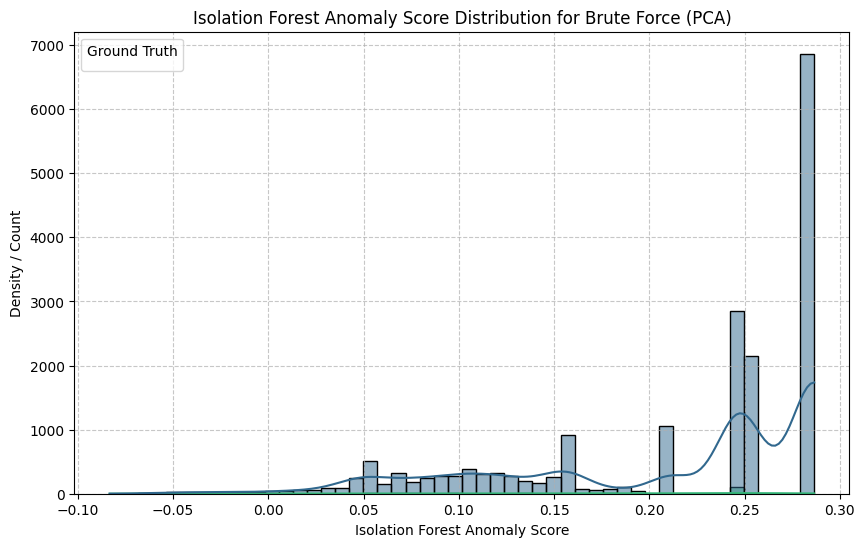

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Retrieve the Isolation Forest test scores and corresponding ground truth labels
attack_type = 'brute_force'
selection_method = 'pca'

if_test_scores = results[attack_type][f'{selection_method}_test_scores']
y_test = results[attack_type][f'{selection_method}_y_test']

# Create a DataFrame for plotting
plot_df = pd.DataFrame({
    'Anomaly Score': if_test_scores,
    'Ground Truth': y_test
})

# Map ground truth labels to more descriptive names for the legend
plot_df['Ground Truth Label'] = plot_df['Ground Truth'].map({0: 'Normal', 1: 'Anomaly'})

# 2. Create a histogram or a kernel density estimate (KDE) plot
plt.figure(figsize=(10, 6))
sns.histplot(data=plot_df, x='Anomaly Score', hue='Ground Truth Label', kde=True, bins=50, palette='viridis', common_norm=False)

# 4. Add appropriate labels and a title
plt.xlabel('Isolation Forest Anomaly Score')
plt.ylabel('Density / Count')
plt.title(f'Isolation Forest Anomaly Score Distribution for {attack_type.replace("_", " ").title()} ({selection_method.upper()})')
plt.legend(title='Ground Truth')
plt.grid(True, linestyle='--', alpha=0.7)

# 5. Display the plot
plt.show()

**Why I changed the plotting code**:

Seaborn's `histplot` automatically creates a legend when `hue` is used. I saw a UserWarning because I also called `plt.legend()` afterward. I removed the redundant `plt.legend()` call and adjusted the plotting code so the legend is handled by Seaborn itself. This keeps the code cleaner and avoids the warning.

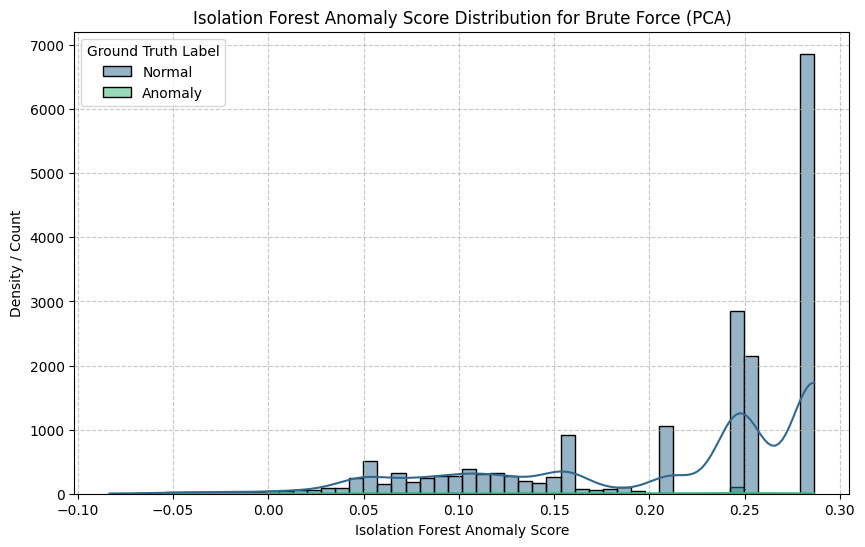

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Retrieve the Isolation Forest test scores and corresponding ground truth labels
attack_type = 'brute_force'
selection_method = 'pca'

if_test_scores = results[attack_type][f'{selection_method}_test_scores']
y_test = results[attack_type][f'{selection_method}_y_test']

# Create a DataFrame for plotting
plot_df = pd.DataFrame({
    'Anomaly Score': if_test_scores,
    'Ground Truth': y_test
})

# Map ground truth labels to more descriptive names for the legend
plot_df['Ground Truth Label'] = plot_df['Ground Truth'].map({0: 'Normal', 1: 'Anomaly'})

# 2. Create a histogram or a kernel density estimate (KDE) plot
plt.figure(figsize=(10, 6))
sns.histplot(data=plot_df, x='Anomaly Score', hue='Ground Truth Label', kde=True, bins=50, palette='viridis', common_norm=False)

# 4. Add appropriate labels and a title
plt.xlabel('Isolation Forest Anomaly Score')
plt.ylabel('Density / Count')
plt.title(f'Isolation Forest Anomaly Score Distribution for {attack_type.replace("_", " ").title()} ({selection_method.upper()})')
plt.grid(True, linestyle='--', alpha=0.7)

# 5. Display the plot
plt.show()

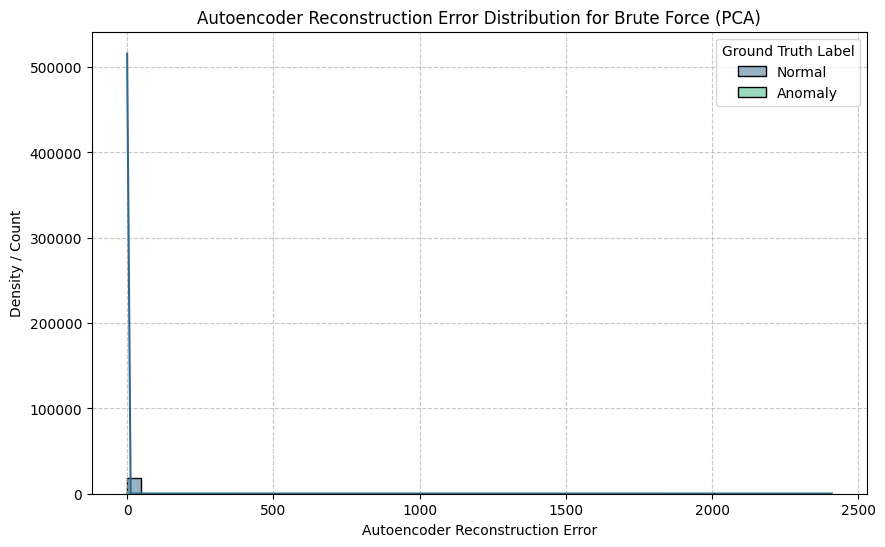

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# 1. Retrieve the Autoencoder test reconstruction errors and corresponding ground truth labels
attack_type = 'brute_force'
selection_method = 'pca'

ae_test_errors = results[attack_type][f'{selection_method}_test_reconstruction_errors']
y_test = results[attack_type][f'{selection_method}_y_test']

# 2. Create a Pandas DataFrame for plotting
plot_df = pd.DataFrame({
    'Reconstruction Error': ae_test_errors,
    'Ground Truth': y_test
})

# 3. Add a new column to plot_df called 'Ground Truth Label'
plot_df['Ground Truth Label'] = plot_df['Ground Truth'].map({0: 'Normal', 1: 'Anomaly'})

# 4. Create a histogram or KDE plot
plt.figure(figsize=(10, 6))
sns.histplot(data=plot_df, x='Reconstruction Error', hue='Ground Truth Label', kde=True, bins=50, palette='viridis', common_norm=False)

# 5. Add appropriate labels for the x and y axes
plt.xlabel('Autoencoder Reconstruction Error')
plt.ylabel('Density / Count')

# 6. Add a title to the plot
plt.title(f'Autoencoder Reconstruction Error Distribution for {attack_type.replace("_", " ").title()} ({selection_method.upper()})')

# 7. Add a grid to the plot for better readability
plt.grid(True, linestyle='--', alpha=0.7)

# 8. Display the plot
plt.show()

## Comparing ROC AUC across models and feature sets

I collect ROC AUC scores for each combination of attack type, feature-selection method, and model. The plot below helps me quickly spot which combinations are worth investigating further.

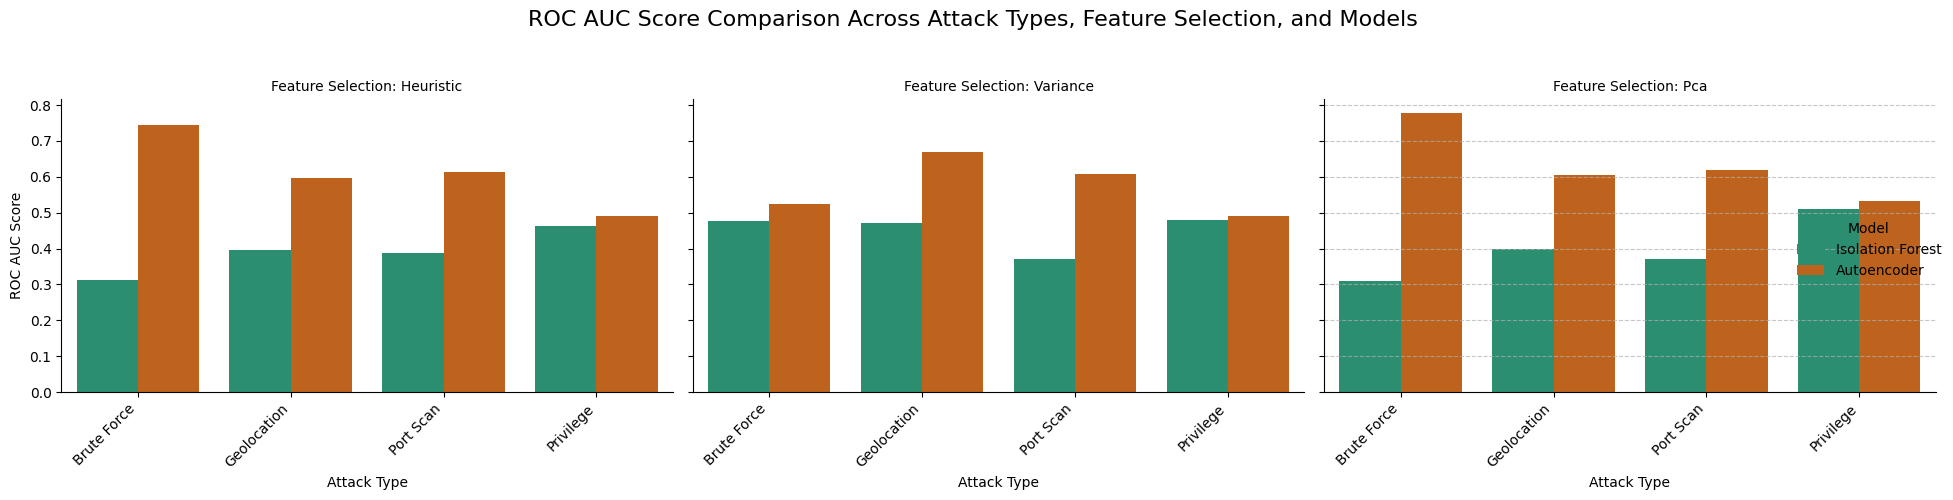

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Initialize an empty list to store performance data
performance_data = []

# Define selection method prefixes for iteration consistency
selection_method_prefixes = ['heuristic', 'variance', 'pca']

# 2. Iterate through each attack_type and its methods in the results dictionary
for attack_type, methods in results.items():
    # 3. For each attack_type, iterate through the selection_method_prefixes
    for prefix in selection_method_prefixes:
        # 4. Check for Isolation Forest ROC AUC scores
        if_roc_auc_key = f'{prefix}_if_roc_auc'
        if if_roc_auc_key in methods:
            performance_data.append({
                'Attack Type': attack_type.replace('_', ' ').title(),
                'Feature Selection': prefix.title(),
                'Model': 'Isolation Forest',
                'Metric': 'ROC AUC',
                'Score': methods[if_roc_auc_key]
            })

        # 5. Check for Autoencoder ROC AUC scores
        ae_roc_auc_key = f'{prefix}_ae_roc_auc'
        if ae_roc_auc_key in methods:
            performance_data.append({
                'Attack Type': attack_type.replace('_', ' ').title(),
                'Feature Selection': prefix.title(),
                'Model': 'Autoencoder',
                'Metric': 'ROC AUC',
                'Score': methods[ae_roc_auc_key]
            })

# 6. Convert the list of performance data into a Pandas DataFrame
performance_df = pd.DataFrame(performance_data)

# 7. Filter the DataFrame to include only 'ROC AUC' metrics (redundant here, but good practice)
roc_auc_df = performance_df[performance_df['Metric'] == 'ROC AUC']

# 8. Create a grouped bar chart using seaborn.catplot
g = sns.catplot(data=roc_auc_df, x='Attack Type', y='Score', hue='Model', col='Feature Selection',
                kind='bar', palette='Dark2', dodge=True, col_wrap=3, height=5, aspect=1.2)

# 9. Add appropriate labels and a title
g.set_axis_labels('Attack Type', 'ROC AUC Score')
g.set_titles('Feature Selection: {col_name}')
g.set_xticklabels(rotation=45, ha='right')
plt.suptitle('ROC AUC Score Comparison Across Attack Types, Feature Selection, and Models', y=1.02, fontsize=16)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout(rect=[0, 0.03, 1, 0.98]) # Adjust layout to prevent suptitle overlap

# Display the plot
plt.show()


## Comparing Average Precision across models and feature sets

I'll extract Average Precision scores from the results dictionary and plot a faceted bar chart. This helps me see how well each model ranks true anomalies relative to false positives across attack types and feature-selection strategies.

**How I'm plotting Average Precision**:

I collect Average Precision values from `results`, organize them into a DataFrame, and then use `seaborn.catplot` to generate faceted bar charts. This makes model comparisons easier to read across attack types and selection methods.

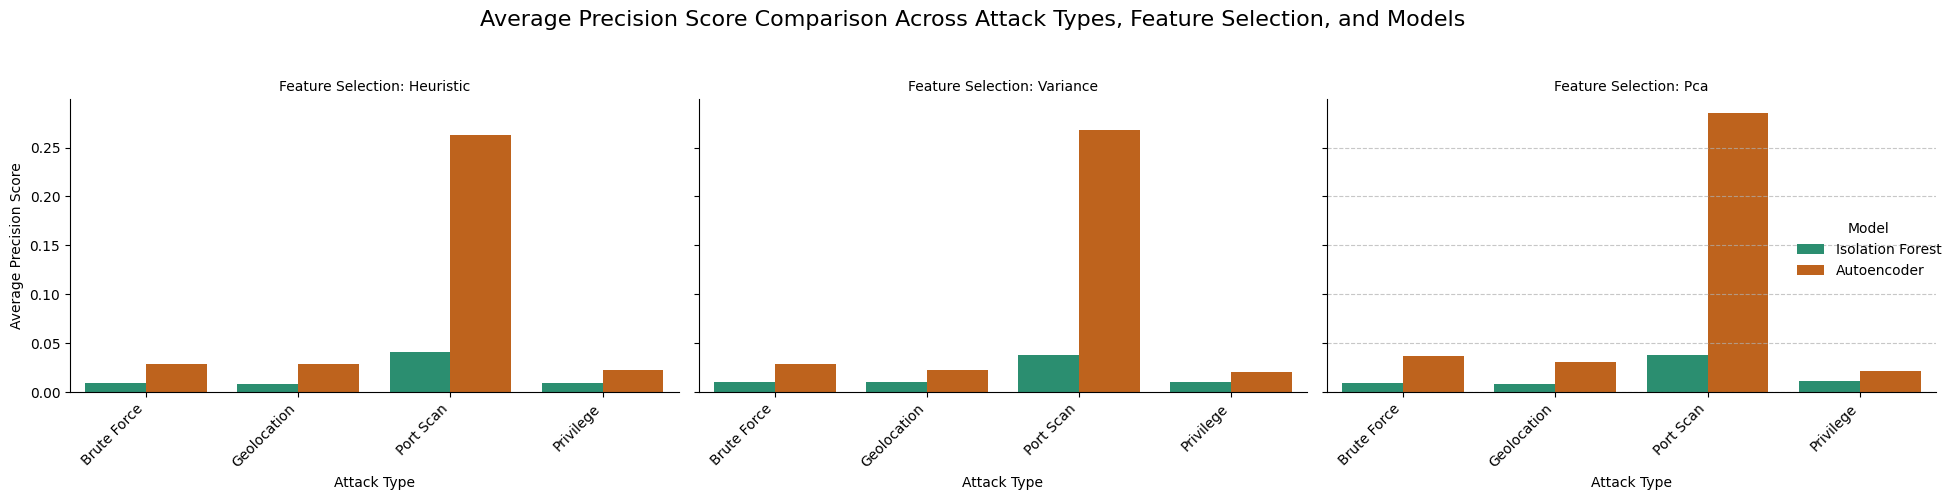

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Initialize an empty list to store Average Precision scores
performance_data_ap = []

# 2. Define selection method prefixes for iteration consistency
selection_method_prefixes = ['heuristic', 'variance', 'pca']

# 3. Iterate through each attack_type and its methods in the results dictionary
for attack_type, methods in results.items():
    # a. For each attack_type, iterate through the selection_method_prefixes
    for prefix in selection_method_prefixes:
        # i. Check for Isolation Forest Average Precision scores
        if_avg_precision_key = f'{prefix}_if_avg_precision'
        if if_avg_precision_key in methods:
            performance_data_ap.append({
                'Attack Type': attack_type.replace('_', ' ').title(),
                'Feature Selection': prefix.title(),
                'Model': 'Isolation Forest',
                'Metric': 'Average Precision',
                'Score': methods[if_avg_precision_key]
            })

        # ii. Check for Autoencoder Average Precision scores
        ae_avg_precision_key = f'{prefix}_ae_avg_precision'
        if ae_avg_precision_key in methods:
            performance_data_ap.append({
                'Attack Type': attack_type.replace('_', ' ').title(),
                'Feature Selection': prefix.title(),
                'Model': 'Autoencoder',
                'Metric': 'Average Precision',
                'Score': methods[ae_avg_precision_key]
            })

# 4. Convert the list of performance data into a Pandas DataFrame
avg_precision_df = pd.DataFrame(performance_data_ap)

# 5. Create a grouped bar chart using seaborn.catplot
g = sns.catplot(data=avg_precision_df, x='Attack Type', y='Score', hue='Model', col='Feature Selection',
                kind='bar', palette='Dark2', dodge=True, col_wrap=3, height=5, aspect=1.2)

# 6. Set the x-axis label to 'Attack Type' and the y-axis label to 'Average Precision Score'
g.set_axis_labels('Attack Type', 'Average Precision Score')
# 7. Set the titles for each facet
g.set_titles('Feature Selection: {col_name}')
# 8. Rotate the x-tick labels by 45 degrees and align them to the right
g.set_xticklabels(rotation=45, ha='right')
# 9. Add a main title to the plot
plt.suptitle('Average Precision Score Comparison Across Attack Types, Feature Selection, and Models', y=1.02, fontsize=16)
# 10. Add a grid to the y-axis for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)
# 11. Adjust the plot layout to prevent the super title from overlapping
plt.tight_layout(rect=[0, 0.03, 1, 0.98]) # Adjust layout to prevent suptitle overlap

# 12. Display the plot
plt.show()

## Visualizing the best model

After computing metrics I identify the best-performing combination and produce a visualization (scatter or distribution) of its anomaly scores or reconstruction errors against ground truth. This helps me sanity-check the model behavior.

Best Model Found: Autoencoder for Brute Force with Pca features (ROC AUC: 0.7770)


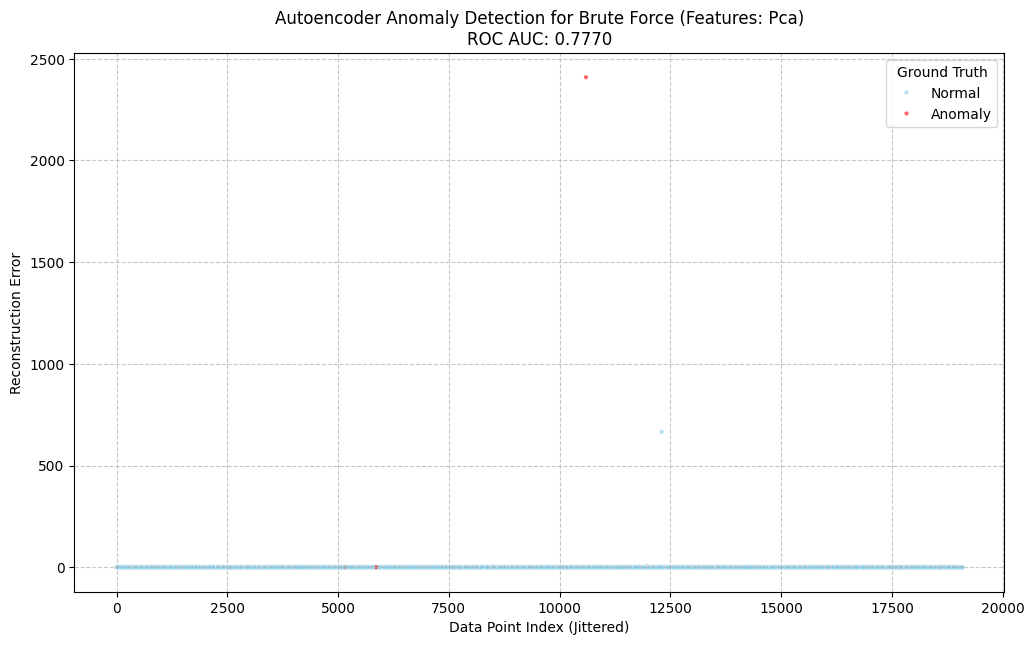

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# 1. Initialize variables to store the best ROC AUC score and its details
best_roc_auc = -1
best_attack_type = None
best_selection_method = None
best_model_type = None

# 2. Iterate through the results dictionary to find the combination with the highest ROC AUC score
for attack_type, methods in results.items():
    for prefix in ['heuristic', 'variance', 'pca']:
        # Check Isolation Forest ROC AUC
        if_roc_auc_key = f'{prefix}_if_roc_auc'
        if if_roc_auc_key in methods:
            score = methods[if_roc_auc_key]
            if score > best_roc_auc:
                best_roc_auc = score
                best_attack_type = attack_type
                best_selection_method = prefix
                best_model_type = 'Isolation Forest'

        # Check Autoencoder ROC AUC
        ae_roc_auc_key = f'{prefix}_ae_roc_auc'
        if ae_roc_auc_key in methods:
            score = methods[ae_roc_auc_key]
            if score > best_roc_auc:
                best_roc_auc = score
                best_attack_type = attack_type
                best_selection_method = prefix
                best_model_type = 'Autoencoder'

print(f"Best Model Found: {best_model_type} for {best_attack_type.replace('_', ' ').title()} with {best_selection_method.title()} features (ROC AUC: {best_roc_auc:.4f})")

# 3. Retrieve the test anomaly scores/reconstruction errors and y_test labels for the best combination
if best_model_type == 'Isolation Forest':
    test_scores_key = f'{best_selection_method}_test_scores'
    anomaly_scores = results[best_attack_type][test_scores_key]
    metric_label = 'Anomaly Score'
else: # Autoencoder
    test_errors_key = f'{best_selection_method}_test_reconstruction_errors'
    anomaly_scores = results[best_attack_type][test_errors_key]
    metric_label = 'Reconstruction Error'

y_test_key = f'{best_selection_method}_y_test'
y_test = results[best_attack_type][y_test_key]

# Create a DataFrame for plotting
plot_df = pd.DataFrame({
    metric_label: anomaly_scores,
    'Ground Truth': y_test
})

# Map ground truth labels to more descriptive names for the legend
plot_df['Ground Truth Label'] = plot_df['Ground Truth'].map({0: 'Normal', 1: 'Anomaly'})

# 4. Create a scatter plot
plt.figure(figsize=(12, 7))
sns.scatterplot(
    data=plot_df,
    x=np.random.rand(len(plot_df)) * (plot_df.index.max() - plot_df.index.min()) + plot_df.index.min(), # Jittered x-axis
    y=metric_label,
    hue='Ground Truth Label',
    palette={'Normal': 'skyblue', 'Anomaly': 'red'},
    alpha=0.6,
    s=10 # Smaller point size for large datasets
)

# 5. Add appropriate labels and a title
plt.xlabel('Data Point Index (Jittered)')
plt.ylabel(metric_label)
plt.title(f'{best_model_type} Anomaly Detection for {best_attack_type.replace("_", " ").title()} (Features: {best_selection_method.title()})\nROC AUC: {best_roc_auc:.4f}')
plt.legend(title='Ground Truth')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()